In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 300)

In [2]:
import json

with open("../data/fix_ipc_class_dict.json") as json_file:
    ipc_class_dict = json.load(json_file)

In [3]:
#df = pd.read_csv("../data/subest1_filtrato.csv")
df = pd.read_csv("../data/data_subset1.csv")

In [4]:
df.title = df.title.str.lower()
df.abstract = df.abstract.str.lower()
df.claims = df.claims.str.lower()
df.ipc_classes = df.ipc_classes.apply(lambda x: x.replace(",", ", ") if type(x)==str else "")

In [5]:
df.head()

,filename,filing_date,publication_date,priority_date,ipc_classes,assignee,inventors,docdb_family_id,title,abstract,claims
0,US2009216698_A1.txt,2008-02-22,2009-08-27,2008-02-22,"G06F15/18, G06N5/02","XEROX CORPORATIONANDREOLI, JEAN-MARCBOUCHARD, GUILLAUME","ANDREOLI, JEAN-MARCBOUCHARD, GUILLAUME",40999265,temporal events analysis employing tree induction,an events analysis method comprises: optimizing respective to a set of training data a set of branching transition likelihood parameters associating parent events of type k with child events of type k' in branching processes; inferring a most probable branching process for a set of input data co...,1. an events analyzer comprising: a probabilistic branching process learning engine configured to optimize respective to a set of training data a set of branching transition likelihood parameters associating parent events of type k with child events of type k′ in branching processes; and a proba...
1,US2020018760_A1.txt,2019-09-23,2020-01-16,2007-03-27,G01N33/574,IMMUNOVIA,"BORREBAECK, CARL, ARNE, KRISTERWINGREN, LARS, BERTIL, CHRISTER",39493874,protein signature/markers for the detection of adenocarcinoma,the present invention provides a method for determining the presence of pancreatic adenocarcinoma in an individual and/or for determining the survival time of an individual afflicted with pancreatic adenocarcinoma comprising the steps of: (a) providing a serum or plasma sample to be tested; and ...,1. a method for determining the presence of pancreatic adenocarcinoma in an individual comprising the steps of: a) providing a serum or plasma sample to be tested; b) determining a protein signature of the test sample by measuring the presence and/or amount in the test sample of one or more prot...
2,EP3340117_A1.txt,2017-11-15,2018-06-27,2016-12-20,"G06N3/04, G06N3/063",INTEL CORPORATION,"LIN, TSUNG-HAN",60327233,unsupervised learning using neuromorphic computing,"a spiking neural network (snn) is implemented on a neuromorphic computers and includes a plurality of neurons, a first set of the plurality of synapses defining feed-forward connections from a first subset of the neurons to a second subset of the neurons, a second subset of the plurality of syna...","1. a method comprising: defining a spiking neural network (snn) comprising a plurality of artificial neurons interconnected by a plurality of artificial synapses, wherein the snn is to comprise: a first subset of the plurality of synapses to define feedforward connections from a first subset of ..."
3,WO2019070570_A1.txt,2018-10-01,2019-04-11,2017-10-06,A61B5/103,TELLUS YOU CARE,"HSU KEVINCOKE, TANIA",65993331,non-contact activity sensing network for elderly care,"determining a physical state of a person includes detecting positions of different portions of the person, transforming detected positions of the person into a point cloud having a density that varies according to movement of each of the portions, correlating movement and position data from the ...","1. a method of determining a physical state of a person, comprising:detecting positions of different portions of the person;transforming detected positions of the person into a point cloud having a density that varies according to movement of each of the portions;correlating movement and positio..."
4,US2016259635_A1.txt,2015-03-04,2016-09-08,2015-03-04,"G06F15/18, G06F17/27, G06F8/65, G06F8/71, G06F9/44, G06F9/445, G06N99/00",IBM (INTERNATIONAL BUSINESS MACHINES CORPORATION),"EL MAGHRAOUI, KAOUTARJANN, JOEFONPATTNAIK, PRATAP C.PICKOVER CLIFFORD A.",56849635,software patch management incorporating sentiment analysis,"a method and system are provided. the method includes generating, by a machine-based sentiment prediction generator, respective machine-determined sentiment predictions for each of a plurality of software patches using sentiment analysis. the method further includes setting, by a sentiment-based...","1. 1-18. (canceled)19. a computer program product for softwar

In [6]:
len(df)

216986

<h3>Keyword della professoressa:</h3>

<img src="keyword prof.png" style="width:800px;"/>

In [194]:
keywords_other = []
"""["molecule",
                  "particle", 
                  "pharmacological",
                  "technolog",
                  "nano(-| )?tech(nolog)?",
                  "alter(ing)?",
                  "nano",
                  "nano(-| )?bot",
                  "nano(-| )?emulsion",
                  "nano(-| )?particle",
                  "nano(-| )?tube",
                  "nano(-| )?sphere",
                  "quantum",
                  "graphene",
                  "cloud",
                  "software",
                  "product"
                 ]"""

"""
Possiamo cercare i vincoli espressi dalla professoressa sia in "stile pandas" 
    (cercare documenti che contengono sia "body" che "care": df[(df.body >= 1) & (df.care >= 1)])
    
    che tramite l'uso delle espressioni regolari per implmentare l'operatore che l'Ing Ghironi 
    ha chiamto NEAR. Ad esempio per cercare "skin NEAR care" possiamo aggiungere alla lista sotto
    "lip(\w|\W){1,20}?stick". Agli estremi ci sono le 2 parole in cui siamo interessati, 
    "(\w|\W){1,20}?" serve invece a dire "permetti la presenza tra 
    0 e 20 caratteri o numeri tra le 2 parole". Se volete fare dei test: https://pythex.org/
"""

keywords_cosmetics = ["cosmetic",
                      "beauty", 
                      "body", 
                      "skin", 
                      "nail", 
                      "fingernail", 
                      "cleans(e|ing)", # 
                      "manicur(e|ing)", #manicure and manicuring
                      "pedicur(e|ing)",
                      "varnish", 
                      "polish",
                      "nail(s| |-)*polish",
                      " lip(s)?",
                      "lip( |-)?stic( |k)+",
                      "blush",
                      "mascara",
                      "make(s| |-)*up",#makes up, make-up
                      " cream",
                      " soap",
                      "toothpaste",
                      "sunscreen",
                      "lotion",
                      "deodorant",
                      "care",
                      "lip(s| |-)*(care|polish)",
                      "skin(s| |-)*(care|polish)",
                      "skin(s| |-)*(care|polish)",
                      "nail(s| |-)*(care|polish)",
                      "baby(s| |-)*(care|polish)",
                      "anti(-)?ag(e|ing)",
                      "colour|color",
                      "finger",
                      "sunscreen",
                      "serum",
                      "hangnail",
                      "exfoliation",
                      "derma",
                      "fragrance",
                      "eyebrow",
                      "personal( )?care"
                     ]

In [8]:
df_original = df.copy()

### Controllo IPC (DA AFFINARE)
##### IPC A45D+

HAIRDRESSING OR SHAVING EQUIPMENT ; EQUIPMENT FOR COSMETICS OR COSMETIC TREATMENTS, e.g. FOR MANICURING OR PEDICURING

In [9]:
df_selected = pd.DataFrame()

In [12]:
df_candidate = df[(df.ipc_classes.str.count("(^| )A45D")>0)
                 & (df.ipc_classes.str.count("(^| )G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("(^| )A61B5")==0) #	Measuring for diagnostic purposes
                 ]
df_candidate[["title", "ipc_classes","claims"]] 

,title,ipc_classes,claims
3240,system for dispensing at least one makeup product and method for dispensing and evaluating makeup,"A45D40/00, A45D40/26, A45D44/00, B01F13/10, B01F15/02, B01F5/06, G01J3/46","1. a system for dispensing at least one makeup product and that can be manipulated in one hand, the system comprising: a cup; and a dispenser for filling the cup from a bottom of the cup with at least two base products, wherein: the cup is secured to the dispenser at least while the cup is being..."
20938,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04","1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."
31462,training system and device,"A45D1/00, G09B19/00, G09B19/24, G09B5/04","1. a beauty product system for performing a treatment on a user, the system comprising:an input for allowing the user to specify a desired treatment to be performed; a beauty product device that is manipulate by the user to perform the desired treatment on the user; the beauty product device hav..."
38540,cosmetic cleaning product,"A45D34/04, A61H15/02, A61H7/00, A61K8/00, A61K8/02, A61K8/31, A61K8/37, A61K8/42, A61K8/44, A61Q19/10, A61Q5/02","1. a cosmetic cleaning product, comprising: a massage applicator comprising a container body and a massage device having (a) at least one massage pin device, said pin device having at least one first surface which is configured to be in contact with the surface to be massaged, wherein a force ca..."
53114,portable apparatus for supporting a hand held hair dryer,"A45D20/12, A45D20/14, F16M11/00, F16M13/02","1. a portable hair dryer support apparatus, comprising: a hair dryer holding structure for holding a hair dryer; at least one vertical support element pivotally and directly connected at a bottom end to the hair dryer holding structure via a hinge having an axis of rotation perpendicular to the ..."
53136,improvements in and relating to hair irons,"A45D1/06, A45D1/28",1. an electric hair iron comprising at least one heating element and control means comprising a temperature sensor and a control circuit and wherein the control means is arranged such that power is only supplied to the heating element or elements when the temperature sensed by the sensor is at o...
61966,complete compact,"A45D33/00, A45D33/26, A45D44/00, G01N1/22, G01N1/24","i claim:1. a method for determining aroma comprising: (a) providing at least one means of aroma sensing capable of approximately discerning the presence or absence of at least one characteristic of the aroma, (b) sampling aroma with said aroma sensing means, (c) discerning said aroma characteris..."
63517,disposable single use applicator assembly with a chemical composition,"A45D37/00, A45D40/00, A45D40/26, A61K8/04, A61Q19/00","i claim:1. an assembly for storing and transporting, said assembly comprising: a wrapper having a top sheet and a bottom sheet, said top sheet being sealed to said bottom sheet so as to form a border along a perimeter of said top sheet and said bottom sheet; and an insert having a top surface an..."
69896,method for simulating the rendering of a make-up product on a body area,A45D44/00,"1. a method (200) for simulating a rendering of a makeup product on a body area, the method being performed by a processor (1 1 ), and comprising :o acquiring (210) an image of the body area without makeup of a subject, o determining (230) first color parameters of the pixels of the image corres..."
81748,system for targeted application of topical agents to an isolated body part,"A45D40/30, A45D44/00, A61K8/02, A61K8/368, A61P17/10, A61Q19/00, B32B38/10, B32B7/06, B33Y10/00, B33Y80/00, B44C3/02",1. a method for targeted application of topical agents to an isolated

In [13]:
df_selected = pd.concat([df_selected, df_candidate])

len(df_selected)

26

##### IPC C11B9/00 (riportato nelle slide come C11B/009)

In [14]:
df_candidate = df[(df.ipc_classes.str.count("(^| )C11B9/00")>0)
                 & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                 ]
df_candidate[["title", "ipc_classes","claims"]] 

,title,ipc_classes,claims
5337,method of making perfumed goods,"C11B9/00, C11D3/50","1. a method comprising: a.) using an odt value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, wherein said p..."
135822,method of resolving allergens in perfume ingredients,"B01J20/26, B01J20/281, C11B9/00, G01N30/46, G01N30/86, G16C20/20","1. a method of resolving defined known or suspected allergens in a complex mixture of perfume ingredients using two-dimensional gas chromatography (2d-gc), wherein the combination of first and second stationary phases is selected on the basis of a clustering analysis of defined known or suspecte..."
174990,method of making perfumed goods,"A61L9/01, A61Q19/00, C11B9/00, C11D3/22, C11D3/50",what is claimed is:1. a method comprising:a.) using a malodour reduction value determined by mathematical modelling toselect one or more perfume raw materials;b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product. 2. the me...
210149,"methods for identifying, compounds identified and compositions thereof","A23L27/00, C11B9/00","1. a flavor/fragrance composition, comprising an effective amount of one or more compounds selected from tables 1-42.2. the flavor/fragrance composition of claim 1, wherein the composition is formulated as a spray, lotion, foam, gel, suspension, or emulsion.3. the flavor/fragrance composition of..."


In [15]:
df_selected = pd.concat([df_selected, df_candidate])

len(df_selected)

30

## Analisi Per keyword
#### Vedi slides Ing. Ghironi

In [195]:
for key in tqdm(keywords_cosmetics):
    df[key] = df.title.str.count(key).fillna(0) + df.abstract.str.count(key).fillna(0) + df.claims.str.count(key).fillna(0)
    
for key in tqdm(keywords_other):
    df[key] = df.title.str.count(key).fillna(0) #+ df.abstract.str.count(key).fillna(0) + df.claims.str.count(key).fillna(0)

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [129]:
df["total_cosmetics"] = 0
for key in keywords_cosmetics:
    if key == "body" or key == "lip(s)?": continue
    df["total_cosmetics"] += df[key]
    
df["total_other"] = 0
for key in keywords_other:
    df["total_other"] += df[key]

In [18]:
keywords_cosmetics

['cosmetic',
 'beauty',
 'body',
 'skin',
 'nail',
 'fingernail',
 'cleans(e|ing)',
 'manicur(e|ing)',
 'pedicur(e|ing)varnish',
 'polish',
 'nail(s| |-)*polish',
 'lip(s)?',
 'lip( |-)?stic( |k)+',
 'blush',
 'mascara',
 'make(s| |-)*up',
 'cream',
 'soap',
 'toothpaste',
 'sunscreen',
 'lotion',
 'deodorant',
 'care',
 'lip(s| |-)*(care|polish)',
 'skin(s| |-)*(care|polish)',
 'skin(s| |-)*(care|polish)',
 'nail(s| |-)*(care|polish)',
 'baby(s| |-)*(care|polish)',
 'anti(-)?ag(e|ing)',
 'colour|color',
 'finger']

##### cosmetic

In [19]:
keyword = keywords_cosmetics[0]
keyword

'cosmetic'

In [20]:
df[df[keyword] > 0][["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
1827,in vitro toxicogenomics for toxicity prediction using probabilistic component modeling and a compound-induced transcriptional response pattern,"C12Q1/68, C12Q1/6876, G06F19/12, G06F19/20, G16B20/00, G16B25/00, G16B5/00, G16C20/10, G16C20/30, G16C20/70","a novel method to predict toxicity and dose-dependent effects of an agent based on transcriptomic data analysis, by determining a predictive toxicogenomics space (ptgs) score. the ptgs score helps to predict and model the toxicity of compounds typically consisting of chemicals, pharmaceuticals, ...","1. a method of defining a predictive toxicogenomics space, ptgs, score indicative of a toxicity prediction for an agent, said method comprising: transforming gene data defining, for each instance of a plurality of instances, differential gene expression of genes in a test biological sample induc..."
3240,system for dispensing at least one makeup product and method for dispensing and evaluating makeup,"A45D40/00, A45D40/26, A45D44/00, B01F13/10, B01F15/02, B01F5/06, G01J3/46","a system for dispensing at least one makeup product, including a cup and a dispenser for filling the cup from the bottom with at least one product, the cup being secured to the dispenser at least while it is being filled with said product. the method for dispensing and evaluating makeup, includi...","1. a system for dispensing at least one makeup product and that can be manipulated in one hand, the system comprising: a cup; and a dispenser for filling the cup from a bottom of the cup with at least two base products, wherein: the cup is secured to the dispenser at least while the cup is being..."
5009,automated characterization and classification of microoganisms,"G01N21/65, G01N33/569","the present invention relates to an instrument, method, use and software program to obtain information rapidly about microorganisms that may spread uncontrolled in hospitals, water supply, food or when used in bio terrorism. vibrational spectroscopy provides data to a computer linked to one or m...","1. an instrument comprising a vibrational spectrometer, a processing means, a first spectral database [10] and a first information database [200], for obtaining information about a microorganism in a sample of interest by establishing vibrational spectroscopic similarity of the microorganism in ..."
6806,methods and systems for dynamic content provisioning,"G06F16/435, G06F16/438, G06F16/483, G06Q50/00","a method, system, and computer program product for dynamic content provisioning, such as for online marketing and product promotion, may include collecting user content from sources based upon collection parameters, and organizing the collected user content for optimization. there may also be th...","1. a system for dynamic content provisioning, comprising: at least one non-transitory memory configured to store computer program code instructions; and at least one processor configured to execute the computer program code instructions to: collect user content from one or more sources based on ..."
7363,personal appliance,"B26B19/38, B26B21/40",a personal appliance. the personal appliance includes a handle having an implement connecting structure. an implement is connected to the implement connecting structure. an implement displacement sensor is positioned in the handle. the implement displacement sensor measures a displacement of the...,"what is claimed is:1. a personal appliance comprising:a. a handle comprising an implement connecting structure;b. an implement connected to the implement connecting structure;c. an implement displacement sensor positioned in the handle, the implement displacement sensor measuring a displacement ..."
7691,systems and methods for measuring and categorizing colors and spectra of surfaces,"A45D44/00, A61B5/00, G01J3/02, G01J3/46","a color categorization system and method is described. the method comprises the steps of taking at least one color or spectral measurem

In [26]:
#escludiamo tutti i sistemi per "raccomandare un prodotto"

df_candidate = df[(df[keyword] > 0) 
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("A01N")==0) #SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS, DETAILS, OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS, IN GENERAL
                  & (df.ipc_classes.str.count("(^| )A")>0)].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","claims"]] 

,filename,title,ipc_classes,claims
27784,EP3733278_A1.txt,"moisture control device, moisture control method, program, storage medium, generated substance, product, device and equipment","A23L3/26, A23L3/30, A23L3/32, A23L5/30, A47J37/12, B01J19/08, B01J19/10, B01J19/12","1. a moisture control apparatus, wherein a predetermined voltage or current including a dc component and/or an ac component is applied to at least one electrode that generates at least one of an electric field, a magnetic field, an electromagnetic field, electromagnetic waves, sound waves, and u..."
106389,US2012003728_A1.txt,scalable portable sensory and yield expert system for biomass monitoring and production,"A01G31/02, C12M1/34, F21V33/00, G02F1/01","1. a system for optimizing plant growth in a liquid environment within an enclosed growth chamber, comprising: illumination means for controlling spatial, temporal and spectral characteristics of illumination surrounding the growth chamber, said illumination means comprising an array of individu..."
120991,EP3769852_A1.txt,"pump- actuated dispenser with integrated switch, system and method for remote monitoring of product consumption from said pump- actuated dispenser","A47K5/12, B05B11/00, B05B12/00, B05B15/30, H02N2/18","1. a pump-actuated dispenser (1) comprising: a compression pump (2) and a pump actuator (3) to operate the compression pump (2), the pump actuator (3) having a nozzle (4) for the output of a product to be dispensed, wherein the pump actuator (3) is displaceable between two end positions, a resti..."
166422,US2020405037_A1.txt,cosmetic package including a liquid reservoir,A45D34/04,"the embodiments of the invention in which an exclusive property or privilege is claimed are defined as follows:1. a cosmetic formula container, comprising: a container body configured to retain a portion of a cosmetic formula within a cavity, the container body having a neck configured to receiv..."
182147,US2020329742_A1.txt,"moisture control apparatus, moisture control method, program, storage medium, produced object, product, apparatus, and facility","A23L3/26, A23L3/30, A23L3/32, A23L5/10, A23L5/30, A47J37/12, B01J19/08, B01J19/10, B01J19/12, C02F1/48","1. a moisture control or current comprising: at least one electrode configured to generate at least one of an electric field, a magnetic field, an electromagnetic field, electromagnetic waves, sound waves, and ultrasonic waves, wherein a predetermined voltage or current including a dc component ..."
210149,US2020399558_A1.txt,"methods for identifying, compounds identified and compositions thereof","A23L27/00, C11B9/00","1. a flavor/fragrance composition, comprising an effective amount of one or more compounds selected from tables 1-42.2. the flavor/fragrance composition of claim 1, wherein the composition is formulated as a spray, lotion, foam, gel, suspension, or emulsion.3. the flavor/fragrance composition of..."


In [27]:
df_selected = pd.concat([df_selected, df_candidate])
len(df_selected)

36

##### beauty

In [28]:
keyword = keywords_cosmetics[1]
keyword

'beauty'

In [32]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("C12Q")==0) #MEASURING OR TESTING PROCESSES INVOLVING ENZYMES, NUCLEIC ACIDS ...
                  & (df.ipc_classes.str.count("H04")==0) #ELECTRIC COMMUNICATION TECHNIQUE
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
5337,US2016369204_A1.txt,method of making perfumed goods,"C11B9/00, C11D3/50",the present invention relates to methods of designing and making perfumed products and perfume raw materials for use in products and perfume raw materials selected by such methods and the use of same.,"1. a method comprising: a.) using an odt value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, wherein said p..."
7363,WO2019143922_A1.txt,personal appliance,"B26B19/38, B26B21/40",a personal appliance. the personal appliance includes a handle having an implement connecting structure. an implement is connected to the implement connecting structure. an implement displacement sensor is positioned in the handle. the implement displacement sensor measures a displacement of the...,"what is claimed is:1. a personal appliance comprising:a. a handle comprising an implement connecting structure;b. an implement connected to the implement connecting structure;c. an implement displacement sensor positioned in the handle, the implement displacement sensor measuring a displacement ..."
27784,EP3733278_A1.txt,"moisture control device, moisture control method, program, storage medium, generated substance, product, device and equipment","A23L3/26, A23L3/30, A23L3/32, A23L5/30, A47J37/12, B01J19/08, B01J19/10, B01J19/12","provided are a moisture control apparatus, a moisture control method, a program, a storage medium, a produced object, a product, an apparatus, and a facility that can improve the characteristics of an object through moisture control. in a moisture control apparatus according to one aspect of the...","1. a moisture control apparatus, wherein a predetermined voltage or current including a dc component and/or an ac component is applied to at least one electrode that generates at least one of an electric field, a magnetic field, an electromagnetic field, electromagnetic waves, sound waves, and u..."
31462,WO2019122838_A1.txt,training system and device,"A45D1/00, G09B19/00, G09B19/24, G09B5/04",a beauty product device is disclosed which includes a variety of sensors for sensing the way in which a user is operating the device. the sensor data can be processed and compared with pre-stored data representative of a desired style and feedback messages generated and provided back to the user...,"1. a beauty product system for performing a treatment on a user, the system comprising:an input for allowing the user to specify a desired treatment to be performed; a beauty product device that is manipulate by the user to perform the desired treatment on the user; the beauty product device hav..."
62406,US2019224871_A1.txt,personal appliance,"B26B19/38, B26B21/40, B26B21/52",a personal appliance. the personal appliance includes a handle having an implement connecting structure. an implement is connected to the implement connecting structure. an implement displacement sensor is associated with the handle. the implement displacement sensor measures a displacement of t...,"1. a personal appliance comprising: a. a handle comprising an implement connecting structure; b. an implement connected to the implement connecting structure; c. an implement displacement sensor associated with the handle, the implement displacement sensor measuring a displacement of the impleme..."
140736,US2020171687_A1.txt,personal appliance,"B26B19/38, B26B21/40",a personal appliance. the personal appliance includes a handle having an implement connecting structure. an implement is connected to the implement connecting structure. an implement displacement sensor is positioned in the handle. the implement displacement sensor measures a displacement of the...,"1. a personal appliance comprising: a. a handle comprising an implement connecting structure; b. an implement connect

In [33]:
df_selected = pd.concat([df_selected, df_candidate])
len(df_selected)

43

##### body (troppo rumore)

In [34]:
keyword = keywords_cosmetics[2]
keyword

'body'

In [35]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("A63H")==0) #TOYS, e.g. TOPS, DOLLS, HOOPS OR BUILDING BLOCKS
                  & (df.ipc_classes.str.count("G09")==0) #EDUCATION; CRYPTOGRAPHY; DISPLAY; ADVERTISING; SEALS
                  & (df.ipc_classes.str.count("G10")==0) #MUSICAL INSTRUMENTS; ACOUSTICS
                  & (df.ipc_classes.str.count("(^| )A")>0)
                  ].query("title not in @df_selected")[["title", "ipc_classes","abstract", "claims"]]

df_candidate

,title,ipc_classes,abstract,claims
566,systems and methods for data-driven movement skill training,"A63B24/00, A63B69/40, A63B71/06",a data-driven movement skill training system is disclosed. the system uses movement skill assessment and diagnostics at distinct levels of the human movement system hierarchy to specify training goals for a user. the system may provide various augmentations that are synthesized to help the user ...,"1. an apparatus for movement skill training, the apparatus comprising: a sensor system comprising one or more sensors configured to obtain movement data for a subject performing an activity; a processor system in communication with the one or more sensors, the processor system having a microproc..."
2654,mobile robot and control method therefor,"A47L9/28, B25J11/00, B25J19/02, B25J9/00, B25J9/16, G05D1/02",a mobile robot in one general aspect of the present invention includes: a travel drive unit configured to move a main body; an image acquisition unit configured to acquire an image of surroundings of the main body; a sensor unit having one or more sensors configured to sense an object during the...,1. a mobile robot comprising: a travel drive unit configured to move a main body; an image acquisition unit configured to acquire an image of surroundings of the main body; a sensor unit having one or more sensors configured to sense an object during the movement of the main body; a storage conf...
3478,connected food preparation system and method of use,"A23L5/10, A47J36/32, A47J37/06, F24C15/00, F24C3/12, F24C7/08, H04W4/80, H05B1/02","a connected oven, including a set of in-cavity sensors and a processor configured to automatically identify foodstuff within the cooking cavity, based on the sensor measurements; and automatically operate the heating element based on the foodstuff identity.","we claim:1. a connected oven, comprising: an oven body defining a cooking cavity, the oven body comprising an oven base opposing an oven top, the cooking cavity comprising a set of low reflectance surfaces; a set of optical sensors cooperatively defining a field of view, the set of optical senso..."
4902,dribbling and ball control sports training system and method,A63B69/00,"a sports training method is described comprising the following steps: classifying the dribbling and ball or puck control motions into modular predetermined motion sequences according to the sensomotor and technical skills developed, evaluating athlete's skill level in relation to dribbling and b...","1. a sports training method which comprises the following steps: classifying different dribbling and ball or puck control motions into predetermined motion sequences according to the sensomotor and technical skills developed, evaluating athlete's skill level in relation to dribbling and ball ..."
5260,a connected oven,"A23L5/10, A47J36/32, A47J37/06, F24C15/00, F24C3/12, F24C7/06, F24C7/08, H04W4/80, H05B1/02, H05B6/68","a connected oven, including a set of in-cavity sensors and a processor configured to automatically identify foodstuff within the cooking cavity, based on the sensor measurements; and automatically operate the heating element based on the foodstuff identity.","1. a connected oven (100), comprising: • an oven body defining a cooking cavity (200), the oven body comprising an oven base (250) and an oven top (230); • an oven door (210) mounted to the oven body, the oven door (210) comprising: • a transparent window coextensive with the cooking cavity (200..."
8076,multiview body camera system with environmental sensors and alert features,"A41D1/00, A41D1/04, A42B3/04, G02B27/01, H04N5/00, H04N5/225, H04N5/247","a multiview body camera system with a vest, a helmet, shoulder pads, camera units providing video, directional microphones providing audio, sensors providing motion detection and other functions is described herein. a control module controls camera units, microphones, sensors and all other circu...",i claim:1. an enhanced situation

##### skin (da provare combinazioni)

In [36]:
keyword = keywords_cosmetics[3]
keyword

'skin'

In [37]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("G09")==0) #EDUCATION; CRYPTOGRAPHY; DISPLAY; ADVERTISING; SEALS
                  & (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
538,ligands for odor receptors and olfactory neurons,"A01M1/10, A01N33/00, A23L27/10",the disclosure provides compounds useful as insect repellents and compositions comprising such repellents. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.,"1-41. (canceled)42. a composition, comprising one or more compounds selected from table 9, table 10, and any combination thereof, in a trap, a cream, a lotion, a spray, a dust, a vapor emitter, a candle, an oil, a wicked apparatus, a fan, a vaporizer, a perfume, a cologne, a fragrance, a deodora..."
2533,rowing exercise machines having a configurable rowing feel,"A63B21/00, A63B21/005, A63B21/22, A63B22/00, A63B24/00, A63B71/06","among other things, a rowing exercise machine includes a movable inertial element, an eddy current brake coupled to the movable inertial element, a rowing grip coupled to the movable inertial element, and control circuitry coupled to the eddy current brake to cause a resistance to motion of the ...","1. a rowing exercise machine comprising a movable inertial element, an eddy current brake coupled to the movable inertial element, a rowing grip coupled to the movable inertial element, and control circuitry coupled to the eddy current brake to cause a resistance to motion of the rowing grip dur..."
4603,creating music by concatenative synthesis,"A63H5/00, G04B13/00, G10H7/00, H03G5/00","automated creation of new music by listening is disclosed. a method to create new music may comprise listening to a plurality of music, learning from the plurality of music, and performing concatenative synthesis based on the listening and the learning to create the new music. the method may be ...",it is claimed:1. a method to create new music comprising: listening to a plurality of music learning from the plurality of music performing concatenative synthesis based on the listening and the learning to create the new music.2. the method of claim 1 wherein the music comprises at least one of...
11876,personally powered appliance,"A43B3/00, G08B21/02, H01L41/113, H04B1/38, H04Q9/00","systems and methods are disclosed for powering a processor and a wireless transceiver in a sole having a sole plate and one or more spring elements disposed in a forefoot area of the sole plate, each of said spring elements including a piezoelectric generator coupled thereto, wherein each of the...","1. an apparatus, comprising: a processor; a wireless transceiver coupled to the processor; a power supply coupled to the processor and wireless transceiver located proximal to a sole, said sole including: a sole plate; and one or more leaf spring elements extending at an angle from the sole plat..."
12941,devices for prevention of pressure ulcers,"A47C27/00, A47C27/08","a support surface, such as an underpad, for preventing pressure sores in a patient is a multi-layer textile assembly having a skin contact layer formed from a fabric of synthetic filament yarns woven to provide air permeability and moisture vapor permeability and having a thickness of less than ...","1. a support surface for preventing pressure ulcers in a patient, the support surface comprising a multi-layer composite fabric comprising: a skin contact layer comprising a woven fabric of synthetic filament yarns woven to provide air permeability and moisture vapor permeability and having a th..."
15513,computer-implemented question and answer game,A63F9/24,"a computer-implemented question and answer game based on using opinion polls that have already been carried out on a representative sample of people. results of the opinion polls and predefined questions are stored in a knowledge base associated with the system, which is typically implemented on...","1. a method of allocating a prize to at least one individual using a computer system having at least one host computer terminal for presenting and collecting -data, a question engine for sendi

In [38]:
df_selected = pd.concat([df_selected, df[df.title == "personal care device with camera"]])
len(df_selected)

45

##### skin (da provare combinazioni)

In [39]:
keyword = keywords_cosmetics[4]
keyword

'nail'

In [40]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("G16")==0)#NFORMATION AND COMMUNICATION TECHNOLOGY [ICT] SPECIALLY ADAPTED FOR SPECIFIC APPLICATION FIELDS
                  & (df.ipc_classes.str.count("G08")==0)#SIGNALLING
                  & (df.ipc_classes.str.count("G09")==0)#EDUCATION; CRYPTOGRAPHY; DISPLAY; ADVERTISING; SEALS
                  & (df.ipc_classes.str.count("H04")==0)#LECTRIC COMMUNICATION TECHNIQUE
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
10744,"improved microlayer membranes, mproved battery separators, and related methods","B29C48/00, B29C48/08, B29C48/21, B32B27/08, B32B27/32, H01M2/14, H01M2/16","described herein is a multilayer microporous film or membrane that may exhibit improved properties, including improved dielectric break down and strength, compared to prior monolayer or tri-layer microporous membranes of the same thickness. the preferred multilayer microporous membrane comprises...","1. a battery separator for a lithium battery comprising: at least one microporous separator membrane or sub-membrane comprising a plurality of porous or microporous polymer microlayers or nanolayers, wherein at least one of the individual microlayers or nanolayers comprises a different or distin..."
14944,power center assembly having electrical connection-protection and optional detachable surface mount,"H01R13/516, H01R13/66, H01R13/70, H01R25/00, H02G3/18","a power center assembly having a hooded member for protecting an electrical connection between a peripheral device plug and its respective outlet and a mount member for detachably mounting the power center to a surface. in particular, a power center assembly is provided having a member for prote...","1. a power center assembly, comprising: a power strip, said power strip having a housing member and at least one outlet for powering at least one peripheral device, said housing member having a bottom surface; and mechanical means for preventing inadvertent mechanical and electrical disconnec..."
20938,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04",the present disclosure relates to a robotic apparatus and methods for automatic nail polish application on natural or artificial finger or toe nails. the robot uses artificial intelligence (al) to identify and paints the nails. the robot uses depth sensors and computer vision to plan the movemen...,"1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."
22515,system and methods for patient data and treatment management,,"described are systems and methods for the analysis of information, particularly information obtained from the mass spectroscopic (proteomic) analysis of biological samples and associated patient and clinical information. the systems and methods of the invention may be used for a variety of purpo...","what is-1cealmeo fs:11. a system, comprising: a system input to receive a quantity of proteomic data obtained from mass spectrometric analysis of a biological sample; a metadata repository to store a quantity of metadata that includes the quantity of proteomic data; a rules database to store at ..."
27088,interchangeable footwear system and method,"A43B21/36, A43B3/24","a footwear system (s) and corresponding methods (m1) and (m2) for providing a plethora of footwear fashion options via a plurality of interchangeable components, the interchangeability of which being facilitated by structurally stable quick-coupling and quick-decoupling techniques. the system (s...","1. an interchangeable footwear system, comprising: a plurality of interchangeable uppers; a plurality of interchangeable heels; and a quick-release device comprising a rigid slide reversibly fastenable to the plurality of interchangeable uppers and reversibly fastenable to the plurality of inter..."
40165,"improved microlayer membranes, improved battery separators, and related methods","B29C47/06, B32B27/00, H01M10/052, H01M2/14, H01M2/16, H01M2/18","described herein is a multilayer microporous film or membrane that may exhibit improved properties, including improved dielectric break down and strength, compared to prior monolayer or tri-layer microporous membranes 

In [41]:
df_selected = pd.concat([df_selected, df[df.title == "automatic nail polish application system and method"]]) 
len(df_selected)

46

##### fingernail

In [42]:
keyword = keywords_cosmetics[5]
keyword

'fingernail'

In [43]:
df_candidate = df[(df[keyword] > 0)
                 ].query("title not in @df_selected")


df_candidate[["title", "ipc_classes","abstract", "claims"]] #Contiene solo metodi relativi al miglioramento dei dispositivi touch

,title,ipc_classes,abstract,claims
10595,method for improving accuracy of touch screen event analysis by use of spatiotemporal touch patterns,"G06F3/041, G06F3/0484, G06F3/0488","a method of classifying touch screen events uses known non-random patterns of touch events over short periods of time to increase the accuracy of analyzing such events. the method takes advantage of the fact that after one touch event, certain actions are more likely to follow than others. thus ...","1. a method of analyzing touch screen events based on characterization of features derived from each touch event, the method comprising: detecting a sequence of touch events on a touch sensitive surface (100); generating vibro-acoustic waveform signals using at least one sensor (110) associated ..."
23540,method for improving accuracy of touch screen event analysis by use of spatiotemporal touch patterns,"G06F3/041, G06F3/043","a method of classifying touch screen events uses known non-random patterns of touch events over short periods of time to increase the accuracy of analyzing such events. the method takes advantage of the fact that after one touch event, certain actions are more likely to follow than others. thus ...","1. a method of analyzing touch screen events based on characterization of features derived from each touch event, the method comprising: detecting touch events on a touch sensitive surface; generating vibro-acoustic waveform signals using at least one sensor associated with the touch events; con..."
25707,image processing using a convolutional neural network to track a plurality of objects,"G06K9/62, G06N3/04, G06N3/08, G06T11/00, G06T11/60, G06T3/40, G06T7/11, G06T7/194, G06T7/246, G06T7/73","presented is a convolutional neural network (cnn) model for fingernail tracking, and a method design for nail polish rendering. using current software and hardware, the cnn model and method to render nail polish runs in real-time on both ios and web platforms. a use of loss mean pooling (lmp) co...","we claim:1. a computing device comprising a processor and a storage device coupled thereto, the storage device storing a cnn and instructions, which when executed by the processor, configure the computing device to: process an image comprising a plurality of objects with the cnn, the cnn configu..."
35612,system and method for detecting imperfections in a screen,"G01N29/12, G01N29/46, G06F3/041, G06F3/0488","a method and system for detecting imperfections on a surface of a touchscreen of an electrical device, comprising: swiping a test object, such as a fingertip, a fingernail or a pin, along at least a portion of the touchscreen; producing, by the touchscreen, an electric signal indicative of the t...","1. a method of detecting imperfections on a surface of a touchscreen of an electrical device, comprising: swiping a test object along at least a portion of the touchscreen; producing, by the touchscreen, an electric signal indicative of the test object's contact with the touchscreen; receiving a..."
45418,image processing using a convolutional neural network to track a plurality of objects,"G06N3/02, G06N3/08, G06T1/40, G06T7/10, G06T7/194","presented is a convolutional neural network (cnn) model for fingernail tracking, and a method design for nail polish rendering. using current software and hardware, the cnn model and method to render nail polish runs in real-time on both ios and web platforms. a use of loss mean pooling (lmp) co...","w e claim:1. a computing device comprising a processor and a storage device coupled thereto, the storage device storing a cnn and instructions, which when executed by the processor, configure the computing device to: process an image comprising a plurality of objects with the cnn, the cnn config..."
52891,systems and methods for interactive virtual makeup experience,"G06F3/0484, G06F3/0488, G06T11/60, G06T7/136, G06T7/33, G06T7/60, G06T7/73, G06T7/90","a computing device for providing a virtual fingernail cosmetic ex

##### cleans(e|ing)

In [44]:
keyword = keywords_cosmetics[6]
keyword

'cleans(e|ing)'

In [48]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  & (df.ipc_classes.str.count("G01")==0) #Escludo "MEASURING; TESTING"
                  & (df.ipc_classes.str.count("A61")==0) #MEDICAL OR VETERINARY SCIENCE; HYGIENE
                  & (df.ipc_classes.str.count("G16")==0)#NFORMATION AND COMMUNICATION TECHNOLOGY [ICT] SPECIALLY ADAPTED FOR SPECIFIC APPLICATION FIELDS
                  & (df.ipc_classes.str.count("G08")==0)#SIGNALLING
                  & (df.ipc_classes.str.count("G09")==0)#EDUCATION; CRYPTOGRAPHY; DISPLAY; ADVERTISING; SEALS
                  & (df.ipc_classes.str.count("H04")==0)#LECTRIC COMMUNICATION TECHNIQUE
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
136883,electric power grid supply and load prediction using cleansed time series data,"G05B15/02, H02J13/00, H02J3/00","an apparatus includes a processor to: assign each value of each set of values of an initial supply meter data and of an initial load meter data to one of multiple buckets based on weather conditions and/or time and date; for each bucket, generate upper and lower bounds of power provision and pow...","1. an apparatus comprising a processor and a storage to store instructions that, when executed by the processor, cause the processor to perform operations comprising: retrieve initial supply meter data from the storage, wherein: the initial supply meter data comprises, for each supply meter of m..."
142312,back-cleansing unit,"A46B13/04, A47K5/12, A47K7/02, A47K7/03, A47K7/04",an automatic back-cleansing apparatus for fixing to a vertical bath or shower surface includes a main housing section having a rotating head receiving section with gear teeth for engaging rotating heads on a rotating disk section adjacent the main housing section. the rotating disk section inclu...,"1. an automatic back-cleansing apparatus for fixation on a vertical surface, the apparatus comprising: a main housing section; a rotating head receiving section on the main housing section; wall mounting means on the main housing section; and a power producing means, wherein the rotating head re..."
155783,system and method for virtual energy assessment of facilities,"G05B13/02, G05F1/66","embodiments of the invention provide methods and systems to analyze energy consumption and support demand management of a portfolio of facilities. some embodiments of the invention include a computer implemented method for collecting and cleansing street addresses, time series energy consumption...","1. a computer-implemented system for remotely assessing energy performance of a plurality of facilities, the system comprising: a processor; a non-transitory computer-readable storage medium in data communication with the processor, the non-transitory computer-readable storage medium including s..."
169618,power meter based monitoring of elevator usage,B66B5/00,"the invention refers to a system comprising an elevator monitoring device (300) for monitoring at least one elevator (200) operatively coupled to at least one motor (240) which is operatively connected to at least one power meter (260), wherein the elevator monitoring device (300) is configured ...","1. a system (100) comprising an elevator monitoring device (300) for monitoring at least one elevator (200) operatively coupled to at least one motor (240) which is operatively connected to at least one power meter (260), wherein the elevator monitoring device (300) is configured to receive, fro..."
181560,power meter based monitoring of elevator usage,B66B5/00,"the invention refers to a system comprising an elevator monitoring device (300) for monitoring at least one elevator (200) operatively coupled to at least one motor (240) which is operatively connected to at least one power meter (260), wherein the elevator monitoring device (300) is configured ...","patent claims1. a system (100) comprising an elevator monitoring device (300) for monitoring at least one elevator (200) operatively coupled to at least one motor (240) which is operatively connected to at least one power meter (260), wherein the elevator monitoring device (300) is configured to..."
182424,apparatus and method for improved development of oil and gas wells,"E21B41/00, E21B44/00","a system, device and method are described for controlling development of an oil or gas well. data from the well is analysed to provide control signals for the well with the additional feature of cleaning the data in conjunction with the analysis. data is cleaned using knowledge based techniques,...","1. a system for controlling the development of an oil or gas well comprising: a data capture means for receiving well data; a data a

##### manicur(e|ing)

In [49]:
keyword = keywords_cosmetics[7]
keyword

'manicur(e|ing)'

In [51]:
df_candidate = df[(df[keyword] > 0)].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
20938,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04",the present disclosure relates to a robotic apparatus and methods for automatic nail polish application on natural or artificial finger or toe nails. the robot uses artificial intelligence (al) to identify and paints the nails. the robot uses depth sensors and computer vision to plan the movemen...,"1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."


In [52]:
df_selected = pd.concat([df_selected, df_candidate])

len(df_selected)

47

##### pedicur(e|ing)

In [57]:
keyword = keywords_cosmetics[8]
keyword

'pedicur(e|ing)'

In [58]:
df_candidate = df[(df[keyword] > 0)].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims


##### nail(s| |-)*polish

In [63]:
keyword = keywords_cosmetics[11]
keyword

'nail(s| |-)*polish'

In [72]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
20938,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04",the present disclosure relates to a robotic apparatus and methods for automatic nail polish application on natural or artificial finger or toe nails. the robot uses artificial intelligence (al) to identify and paints the nails. the robot uses depth sensors and computer vision to plan the movemen...,"1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."
69896,method for simulating the rendering of a make-up product on a body area,A45D44/00,"the invention proposes a method for simulating a rendering of a makeup product on a body area is disclosed comprising: - acquiring an image of the body area without makeup of a subject, - determining first color parameters of the pixels of the image corresponding to the body area without makeup,...","1. a method (200) for simulating a rendering of a makeup product on a body area, the method being performed by a processor (1 1 ), and comprising :o acquiring (210) an image of the body area without makeup of a subject, o determining (230) first color parameters of the pixels of the image corres..."
158644,method for simulating the rendering of a make-up product on a body area,A45D44/00,"the inventionproposes a method for simulating a rendering of a makeup product on a body area is disclosed comprising:∘ acquiring an image of the body area without makeup of a subject,∘ determining first color parameters of the pixels of the image corresponding to the body area without makeup,∘ i...","1. a method (200) for simulating a rendering of a makeup product on a body area, the method being performed by a processor (11), and comprising : ∘ acquiring (210) an image of the body area without makeup of a subject, ∘ determining (230) first color parameters of the pixels of the image corresp..."


In [73]:
df_selected = pd.concat([df_selected, df[df.title == "automatic nail polish application system and method"]])
len(df_selected)

48

##### 'lip(s)?'

In [84]:
keyword = keywords_cosmetics[12]
keyword

' lip(s)?'

In [85]:
df_candidate = df[(df[keyword] > 10)
                  & (df.ipc_classes.str.count("G06")==0)
                  & (df.ipc_classes.str.count("G(01|11|10|09)")==0)
                  & (df.ipc_classes.str.count("C12Q")==0)
                  & (df.ipc_classes.str.count("C62")==0)
                  & (df.ipc_classes.str.count("B60")==0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
460,intubation delivery systems and methods,"A61B1/00, A61B1/267, A61M16/00, A61M16/04","various methods and systems for delivery of an ett for intubation are provided. in one example, an ett delivery system comprises a rail system, where the rail system comprises at least one rail. in some examples the rail system engages with an ett and at least partially defines an ett delivery p...","1. an ett delivery system, comprising: a rail system comprising at least one rail, where the rail system engages with an ett and at least partially defines an ett delivery path; a delivery mechanism operatively linked with the rail system to deliver the ett along the ett delivery path; and a bla..."
10916,establishing packet data network connectivity for local internet protocol access traffic,"H04L29/12, H04W8/08","providing for establishment of local internet protocol access (lipa) for cellular communication is provided herein. according to particular aspects of the subject disclosure, provided are mechanisms to identify a request to establish a packet network connection as a request for a lipa context. o...","what is claimed is:1. a method of wireless communication for establishing packet connectivity for local internet protocol access (lipa) traffic, comprising: receiving an electronic message comprising a request for a packet data network connection (a pdn connection); determining whether the reque..."
12187,alphavirus neoantigen vectors,"A61K39/00, A61K39/12, A61P31/12, C07K14/47, C07K14/74, C12N15/86","disclosed herein are alphavirus vectors that include neoantigen-encoding nucleic acid sequences derived from a tumor of a subject. also disclosed are nucleotides, cells, and methods associated with the vectors including their use as vaccines.","1. a composition for delivery of a neoantigen expression system, comprising: the neoantigen expression system, wherein the neoantigen expression system comprises one or more vectors, the one or more vectors comprising: (a) an rna alphavirus backbone, wherein the rna alphavirus backbone comprises..."
15782,ingestible device and associated methods,"A61B5/00, A61B5/06, A61B5/145, A61B5/1455","an ingestible device is disclosed which can produce spectral data of one or more analytes, as well as associated methods for characterizing the gastrointestinal tract of a subject which contains such analytes. related kits and systems are also disclosed.","what is claimed is:1 . a device, comprising:a spectrometer configured to generate spectral data of a sample within the gastrointestinal (gl) tract of a subject in vivo,wherein the device is an ingestible device, and the spectral data comprises information useful to determine analyte information ..."
36358,novel tumor-specific antigens for ovarian cancer and uses thereof,"A61K35/12, A61K35/17, A61K39/00, A61K9/127, A61P35/00, A61P37/04, C07K14/47, C07K14/725, C07K14/82, C07K7/06, C12N15/12, C12N5/078, C12N5/10","ovarian cancer, notably high-grade serous ovarian cancer (hgsc), the principal cause of death from gynecological malignancies in the world, has not significantly benefited from recent progress in cancer immunotherapy. while hgsc infiltration by lymphocytes correlates with superior survival, the ...","1. a tumor antigen peptide comprising one of the amino acid sequences set forth in seq id nos: 1 -103.2. the tumor antigen peptide of claim 1 , comprising one of the amino acid sequences set forth in seq id nos: 19-103.3. the tumor antigen peptide of claim 1 or 2, wherein said tumor antigen pept..."
39847,establishing packet data network connectivity for local internet protocol access traffic,"H04W48/00, H04W76/02, H04W8/08, H04W84/04","a method of terminating packet connectivity for local internet protocol access, lipa, traffic involving a wireless communication, comprising: receiving a message that indicates an access terminal is establishing a wireless connection with a base station; determining that an existing lipa pack

In [86]:
df_selected = pd.concat([df_selected, df[df.title == "method and composition for removing waxy soils"]])
len(df_selected)

49

##### 'lip( |-)?stic( |k)+'

In [87]:
keyword = keywords_cosmetics[13]
keyword

'lip( |-)?stic( |k)+'

In [90]:
df_candidate = df[(df[keyword] > 0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
4126,wearable computing device featuring machine-learning-based smoking detection,"G06F3/01, G06F3/0346, G06K9/00",the present disclosure provides a wearable computing device. the wearable computing device includes one or more sensors that output sensor data. the wearable computing device includes a machine-learned smoking gesture detection model trained to detect a smoking gesture based on the sensor data. ...,"1. a wearable computing device, the wearable computing device comprising: one or more sensors that output sensor data; a machine-learned smoking gesture detection model trained to detect a smoking gesture based on the sensor data; one or more processors; and one or more non-transitory computer-r..."
8521,use of artificial intelligence in providing beauty advice,"A45D44/00, A61B5/103, G06F15/00, G06F15/18, G06F17/30, G06F19/00, G06F7/00, G06Q30/06, G06T11/00",the invention may involve using an artificial intelligence engine to provide beauty advice. beauty advice may include a recommendation for a product. the recommended product may be complementary to a second product. the second product may be a user-selected product. a notification of the recomme...,"1. a method of providing beauty advice, the method comprising: receiving user-specific information; accessing a data structure containing information reflecting relationships between categories of user-specific information and beauty advice; comparing, using an artificial intelligence engine, th..."
9218,system and method for augmented reality using conditional cycle-consistent generative image-to-image translation models,"G06F3/01, G06N20/00, G06N3/04, G06N3/08, G06T19/00","systems and methods relate to a network model to apply an effect to an image such as an augmented reality effect (e.g. makeup, hair, nail, etc.). the network model uses a conditional cycle-consistent generative image-to-image translation model to translate images from a first domain space where ...","what we claim is:1. a computing device to translate an image from a first domain space to a second continuous domain space according to an effect to be applied to the image, the computing device comprising: a storage unit storing a conditional cycle-consistent generative image-to-image translati..."
12217,shop-in-shop website construction,"G06F17/30, G06Q30/06","systems, methods, and products may employ a module for use in constructing the first and second websites, such that, using the same module, the first and second websites may incorporate common information while each incorporating information unique to each website. in this way, a brand owner mig...","1. a method for facilitating modular construction of at least portions of first and second websites configured to offer for sale at least one common product, the method comprising: defining at least one module for containing a first set of information for incorporation into a first website, an a..."
52213,"systems and methods for virtual facial makeup removal and simulation, fast facial detection and landmark tracking, reduction in input video lag and shaking, and a method for recommending makeup","A45D44/00, G06K9/00, G06T1/00, G06T17/20, G06T19/20","the present disclosure provides systems and methods for virtual facial makeup simulation through virtual makeup removal and virtual makeup add-ons, virtual end effects and simulated textures. in one aspect, the present disclosure provides a method for virtually removing facial makeup, the method...","1. a method for virtually removing facial makeup, comprising: providing a facial image of a user with makeup applied thereto; locating facial landmarks from the facial image of the user, the facial landmarks including at least a first region and a second region different from the first region; d..."
59157,makeup identification using deep learning,"G06K9/00, G06N3/02, G06T11/00, G06T7/00","makeup identification using deep learning in a digital medium environment is describ

##### blush

In [94]:
keyword = keywords_cosmetics[14]
keyword

'blush'

In [95]:
df_candidate = df[(df[keyword] > 0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
8454,"video surveillance data analysis algorithms, with local and network-shared communications for facial, physical condition, and intoxication recognition, fuzzy logic intelligent camera system",G06F15/18,"this invention relates to intelligent video surveillance fuzzy logic neural networks, camera systems with local and network-shared communications for facial, physical condition and intoxication recognition. the device we reveal helps reduce underage drinking by detecting and refusing entrance or...","1. a fuzzy logic data analysis algorithmic system comprising: a) a local controller, hardware, software, firmware and fuzzy logic including wireless or wired communications interface for communicating with a central controller facility; b) a camera audio and video recording device connected to s..."
8521,use of artificial intelligence in providing beauty advice,"A45D44/00, A61B5/103, G06F15/00, G06F15/18, G06F17/30, G06F19/00, G06F7/00, G06Q30/06, G06T11/00",the invention may involve using an artificial intelligence engine to provide beauty advice. beauty advice may include a recommendation for a product. the recommended product may be complementary to a second product. the second product may be a user-selected product. a notification of the recomme...,"1. a method of providing beauty advice, the method comprising: receiving user-specific information; accessing a data structure containing information reflecting relationships between categories of user-specific information and beauty advice; comparing, using an artificial intelligence engine, th..."
10396,detecting fever and intoxication from video images and a baseline,"A61B5/00, A61B5/01, A61B5/16, G01J5/02, G01J5/12","described herein are embodiments of systems and methods that utilize images of a user's face to detect fever and intoxication. one embodiment of a system to detect fever includes first and second inward-facing head-mounted cameras that are located less than 5 cm from a user's face, are sensitive...","we claim:1. a system configured to detect fever, comprising: first and second inward-facing head-mounted cameras (cam1&2), located less than 5 cm from a user's face, sensitive to wavelengths below 1050 nanometer, and configured to capture images of respective first and second regions on the user..."
12217,shop-in-shop website construction,"G06F17/30, G06Q30/06","systems, methods, and products may employ a module for use in constructing the first and second websites, such that, using the same module, the first and second websites may incorporate common information while each incorporating information unique to each website. in this way, a brand owner mig...","1. a method for facilitating modular construction of at least portions of first and second websites configured to offer for sale at least one common product, the method comprising: defining at least one module for containing a first set of information for incorporation into a first website, an a..."
23099,method and system for managing feature reading and scoring in ultrasound and/or optoacoustice images,"A61B5/00, A61B8/00, A61B8/08","systems, methods and computer program products are provided for reading and scoring ultrasound and/or optoacoustic (us/oa) images that include at least one of oa images or us images acquired in connection with an examination for a region of interest (roi). the system displays a first image that ...","1. a system for managing image reading of at least one of ultrasound (us) images or optoacoustic (oa) images (us/oa images), comprising: a display; a graphical user interface (gui): memory configured to store programmable instructions; one or more processors configured to execute the programmabl..."
23613,methods and systems for characterizing tissue of a subject utilizing a machine learning,"A61B5/00, A61B5/026, A61B5/0275, G06K9/62, G06K9/66, G06T7/00","methods and systems for characterizing tissue of a subject include acquiring and receiving data

##### mascara

In [96]:
keyword = keywords_cosmetics[15]
keyword

'mascara'

In [97]:
df_candidate = df[(df[keyword] > 0)
                 ].query("title not in @df_selected")

df_candidate[["title", "ipc_classes","abstract", "claims"]]

,title,ipc_classes,abstract,claims
8521,use of artificial intelligence in providing beauty advice,"A45D44/00, A61B5/103, G06F15/00, G06F15/18, G06F17/30, G06F19/00, G06F7/00, G06Q30/06, G06T11/00",the invention may involve using an artificial intelligence engine to provide beauty advice. beauty advice may include a recommendation for a product. the recommended product may be complementary to a second product. the second product may be a user-selected product. a notification of the recomme...,"1. a method of providing beauty advice, the method comprising: receiving user-specific information; accessing a data structure containing information reflecting relationships between categories of user-specific information and beauty advice; comparing, using an artificial intelligence engine, th..."
8936,automated imaging system for evaluating the curl of a keratinous substrate,"G06T7/11, G06T7/50, G06T7/73, G06T7/90","a system is provided for evaluating a curl of at least one eyelash sample that includes a plurality of fibers, comprising: a platform configured to receive a sample of the eyelash sample; an image capturing device configured to capture profile image of the eyelash ample; and a processing system ...","1. a system for evaluating a curl of at least one eyelash sample that includes a plurality of fibers, comprising: a platform configured to receive a sample of the eyelash sample; an image capturing device configured to capture profile image of the eyelash sample; and a processing system configur..."
12217,shop-in-shop website construction,"G06F17/30, G06Q30/06","systems, methods, and products may employ a module for use in constructing the first and second websites, such that, using the same module, the first and second websites may incorporate common information while each incorporating information unique to each website. in this way, a brand owner mig...","1. a method for facilitating modular construction of at least portions of first and second websites configured to offer for sale at least one common product, the method comprising: defining at least one module for containing a first set of information for incorporation into a first website, an a..."
95446,method for providing a customized product recommendation,"G06F17/30, G06Q30/06",included is a method for providing a customized product recommendation to a user. images of people are collected from a database. a neural network is used to evaluate the images to identify a consumer trend. information is collected from the user to determine if the user's style or desired style...,1. a method for providing a customized product recommendation to a user comprising the steps of: a. collecting a plurality of images of a plurality of people from a database; b. using a neural network in evaluating the images to identify a consumer trend; c. collecting information from the user ...
116454,body image templates with pre-applied beauty products,"A45D44/00, A61B5/103, G06F19/00, G06T11/00","disclosed methods and systems relate to enabling a beauty analysis. one of the methods involves facilitating display, on a display device, of a plurality of templates, wherein at least some of the templates are representative of a portion of a face having a simulation of use of a beauty product....","1. a method of enabling a beauty analysis, the method comprising: facilitating display, on a display device, of a plurality of templates, wherein at least some of the templates are representative of a portion of a face having a simulation of use of a beauty product; enabling selection of at leas..."
132382,shop-in-a-shop website construction,"G06F17/30, G06Q30/06","systems, methods, and products may employ a module for use in constructing the first and second websites, such that, using the same module, the first and second websites may incorporate common information while each incorporating information unique to each website. in this way, a brand owner mig...","1. a method for facilitating modular constru

##### make(s| |-)*up

In [99]:
keyword = keywords_cosmetics[16]
keyword

'make(s| |-)*up'

In [103]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G06")==0)
                  & (df.ipc_classes.str.count("A01")==0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
1206,US10640392_B2.txt,"water quality management device, water treatment system, water quality management method, and program for optimizing water treatment system","C02F1/00, C02F1/66, C02F1/68, C02F103/02, C02F5/08, F22D11/00, F22D11/02, F28G13/00, G05B13/02",a water quality management device is provided with a water quality index value acquisition unit which acquires water quality index values including a makeup water quality index value indicating water quality of makeup water and a circulating water quality index value indicating water quality of ...,"1. a water quality management system for managing a circulating water system of a plant which includes a circulation line through which circulating water is circulated, a supply line which supplies makeup water to the circulation line, a discharge line which discharges the circulating water from..."
3013,EP3489491_B1.txt,method and system for controlling the products of combustion,"F02C7/057, F02C9/00, F02G3/00, F23R3/26","the present invention relates to methods and systems for controlling a combustion reaction and the products thereof and includes a combustion control system having an oxygen supply stream (104) and a high concentration carbon dioxide stream (102), mixing the streams to form an oxygenation stream...","1. a combustion system, comprising: a high concentration carbon dioxide (co2) stream (102); at least one co2 flow regulation device configured to adjust an overall flow rate of the high concentration co2 stream (102) and split the high concentration co2 stream into a primary diluent stream (102a..."
3240,US10849406_B2.txt,system for dispensing at least one makeup product and method for dispensing and evaluating makeup,"A45D40/00, A45D40/26, A45D44/00, B01F13/10, B01F15/02, B01F5/06, G01J3/46","a system for dispensing at least one makeup product, including a cup and a dispenser for filling the cup from the bottom with at least one product, the cup being secured to the dispenser at least while it is being filled with said product. the method for dispensing and evaluating makeup, includi...","1. a system for dispensing at least one makeup product and that can be manipulated in one hand, the system comprising: a cup; and a dispenser for filling the cup from a bottom of the cup with at least two base products, wherein: the cup is secured to the dispenser at least while the cup is being..."
6611,US2020047336_A1.txt,connection analyzed make-up systems and methods,"B25J9/16, G01L5/00, G01N19/08","a method including acquiring measurements representing torque applied to a connection between a first tubular and a second tubular, a rotational position of the first tubular relative to the second tubular, or both, obtaining a plurality of make-up parameters representing conditions under which ...","1. a method, comprising: acquiring measurements representing torque applied to a connection between a first tubular and a second tubular, a rotational position of the first tubular relative to the second tubular, or both; obtaining a plurality of make-up parameters representing conditions under ..."
14769,US2013226019_A1.txt,system and method for classifying a heart sound,"A61B5/00, A61B5/02, A61B5/0452, A61B5/0456, A61B7/04",a method and system for electronically classifying a pre-processed heart sound signal of a patient as functional (normal) or pathological is provided. the pre-processed patient heart sound signal is segmentised and features are extracted therefrom (104) to build up a feature vector which is repr...,"1. a method of classifying a pre-processed heart sound signal of a patient, the method being characterised in that the pre-processed patient heart sound signal is electronically compared to a plurality of similarly pre-processed heart sounds corresponding to each of a plurality of pathologies an..."
14858,WO2020209725_A1.txt,drilling systems and methods,E21B44/00,"a drilling plant management system (60) comprising a dat

In [104]:
df_selected = pd.concat([df_selected, df[df.title == "water quality management device, water treatment system, water quality management method, and program for optimizing water treatment system"]])
df_selected = pd.concat([df_selected, df[df.title == "wearable pulse waveform measurement system and method"]])
len(df_selected)

53

##### cream

In [105]:
keyword = keywords_cosmetics[17]
keyword

' cream'

In [110]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G(01|06)")==0)
                  & (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
538,US2013236417_A1.txt,ligands for odor receptors and olfactory neurons,"A01M1/10, A01N33/00, A23L27/10",the disclosure provides compounds useful as insect repellents and compositions comprising such repellents. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.,"1-41. (canceled)42. a composition, comprising one or more compounds selected from table 9, table 10, and any combination thereof, in a trap, a cream, a lotion, a spray, a dust, a vapor emitter, a candle, an oil, a wicked apparatus, a fan, a vaporizer, a perfume, a cologne, a fragrance, a deodora..."
15551,US10092235_B2.txt,method and apparatus for enhancing nervous function,"A61B5/00, A61B5/01, A61B5/0205, A61B5/024, A61B5/04, A61B5/0402, A61B5/0476, A61B5/0488, A61B5/053, A61B5/08, A61B5/145","disclosed is a method for interacting with the nervous system. the method includes detecting signals associated with a biological function at one or more sensors. it also includes processing the signals to create a representation thereof, delivering effector responses based on the representation...","1. a method for interacting with the nervous system, the method comprising: detecting signals of normal and abnormal function of a body function of an individual at one or more sensors, without requiring knowledge of the precise neurophysiological mapping of the signals; mathematically processin..."
18306,US2010086501_A1.txt,determining age ranges of skin samples,"A61K31/56, A61K38/16, A61K38/43, A61K8/18, A61Q17/04, C12Q1/68, C40B30/04, C40B40/06","the present invention provides methods for characterizing a skin sample of a subject as belonging to an age range by analyzing nucleic acid or protein molecules obtained from the subject. the methods include analyzing expression or mutations in epidermal samples, of one or more skin markers. the...","1. a method for determining the age range of a skin sample of a subject comprising analyzing nucleic acid from one or more genes listed in table 1, table 2, table 3, or any combination thereof, in a sample of the skin from the subject, thereby determining the age range of the skin of the subject..."
21464,US2020054018_A1.txt,methods for assessing repellant quality of organic materials and methods and compositions for repelling arthropods,"A01N31/02, A01N31/06, A01N33/10, A01N35/02, A01N35/04, A01N35/06, A01N35/10, A01N37/10, A01N37/18, A01N37/20, A01N37/22, A01N37/36, A01N37/44, A01N37/46, A01N43/12, A01N43/16, A01N43/32, A01N43/38, A01N43/40, A01N43/42, A01N43/50, A01N43/54, A01N43/60, A01N43/78, A01N43/90, A01N47/16, A01N47/42,...","the disclosure provides compounds useful as insect repellents, compositions comprising such repellents, and methods of repelling an arthropod using such compounds and compositions. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.","1. a method of repelling an arthropod, comprising exposing the arthropod with a repelling composition, wherein the repelling composition comprises one or more compounds selected from the group consisting of methyl n,n-dimethyl anthranilate, ethyl anthranilate, butyl anthranilate, and 2,3-dimethy..."
22700,US2017164893_A1.txt,method and system for combining physiological and machine information to enhance function,"A61B5/00, A61B5/0205, A61B5/04, A61B5/0408, A61B5/0488, A61B5/0492",the present invention relates generally and specifically to combining biological sensors with external machines using machine learning to form computerized representations that can control effectors to deliver therapy or enhance performance.,"1. a method for interacting with the human body, the method comprising: detecting bodily signals associated with one or more bodily functions at one or more sensors associated with the human body; processing the bodily signals to create one or more sensed signatures of the one of more bod

In [112]:
df_selected = pd.concat([df_selected, df[df.title == "a pump actuating cap for pump dispensers, system and method for remote monitoring of product consumption from said pump actuating cap"]])
df_selected = pd.concat([df_selected, df[df.title == "pump- actuated dispenser with integrated switch, system and method for remote monitoring of product consumption from said pump- actuated dispenser"]])
df_selected = pd.concat([df_selected, df[df.title == "topical/on-the-skin estrogen cream, lotion, ointment, hair tonic, shampoo and wound healing powder"]])
df_selected = pd.concat([df_selected, df[df.title == "method and system for combining physiological and machine information to enhance function"]])
len(df_selected)

58

##### soap

In [115]:
keyword = keywords_cosmetics[18]
keyword

' soap'

In [122]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G(01|06|08)")==0)
                  & (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
27784,EP3733278_A1.txt,"moisture control device, moisture control method, program, storage medium, generated substance, product, device and equipment","A23L3/26, A23L3/30, A23L3/32, A23L5/30, A47J37/12, B01J19/08, B01J19/10, B01J19/12","provided are a moisture control apparatus, a moisture control method, a program, a storage medium, a produced object, a product, an apparatus, and a facility that can improve the characteristics of an object through moisture control. in a moisture control apparatus according to one aspect of the...","1. a moisture control apparatus, wherein a predetermined voltage or current including a dc component and/or an ac component is applied to at least one electrode that generates at least one of an electric field, a magnetic field, an electromagnetic field, electromagnetic waves, sound waves, and u..."
123797,US10839941_B1.txt,systems and methods for evaluating compositions,"G16C20/10, G16C20/30, G16C20/70","a system, apparatus, and/or method is disclosed for determining a value of a property of a considered chemical composition. an identity of a sample chemical composition may be received. a sample chemical composition may comprise ingredients. each of the ingredients may be associated with a value...","1. a method comprising: (a) receiving identities of features of a first composition, each of the features having a value of a predefined characteristic of predefined characteristics; (b) receiving a value of a property of the first composition, wherein the property is affected by an interaction ..."
124966,WO2020060940_A1.txt,systems and methods for predicting skin treatment outcomes using ph information,"G16H20/00, G16H30/40, G16H50/20","in some embodiments, a colorimetric sensor for ph measurement may be used to collect sweat ph information from a subject. an application is provided on a computing device that detects and analyzes the color change in order to determine the ph of sweat detected by the colorimetric sensor. in some...","the embodiments of the invention in which an exclusive property or privilege is claimed are defined as follows:1. a system for generating predictive visualizations of a result of a skin treatment regimen, the system comprising:a server computing system comprising one or more computing devices;at..."
142312,US2017332849_A1.txt,back-cleansing unit,"A46B13/04, A47K5/12, A47K7/02, A47K7/03, A47K7/04",an automatic back-cleansing apparatus for fixing to a vertical bath or shower surface includes a main housing section having a rotating head receiving section with gear teeth for engaging rotating heads on a rotating disk section adjacent the main housing section. the rotating disk section inclu...,"1. an automatic back-cleansing apparatus for fixation on a vertical surface, the apparatus comprising: a main housing section; a rotating head receiving section on the main housing section; wall mounting means on the main housing section; and a power producing means, wherein the rotating head re..."
182147,US2020329742_A1.txt,"moisture control apparatus, moisture control method, program, storage medium, produced object, product, apparatus, and facility","A23L3/26, A23L3/30, A23L3/32, A23L5/10, A23L5/30, A47J37/12, B01J19/08, B01J19/10, B01J19/12, C02F1/48","provided are a moisture control apparatus, a moisture control method, a program, a storage medium, a produced object, a product, an apparatus, and a facility that can improve the characteristics of an object through moisture control. in a moisture control apparatus according to one aspect of the...","1. a moisture control or current comprising: at least one electrode configured to generate at least one of an electric field, a magnetic field, an electromagnetic field, electromagnetic waves, sound waves, and ultrasonic waves, wherein a predetermined voltage or current including a dc component ..."
194808,US2020090800_A1.txt,systems and methods for predicting skin treatment outcomes using s

In [123]:
df_selected = pd.concat([df_selected, df_candidate])

In [124]:
len(df_selected)

65

In [130]:
keyword = keywords_cosmetics[20]
keyword

'sunscreen'

In [131]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
12314,US9535056_B2.txt,immune system modeling devices and methods,"C12M1/00, C12M3/00, C12M3/06, C12Q1/02, G01N33/50, G01N33/53","devices and methods are provided for detecting an immune reaction to a test agent using an immune modeling system comprising a barrier component configured to culture a biological barrier, an immune component configured to culture immune cells, and one or more inter-component microfluidic connec...","1. a method of determining whether of a test agent induces a hypersensitivity reaction, comprising: providing a hypersensitivity modeling device, comprising i) a first culture compartment containing a biological barrier and comprising dendritic cells; ii) a second culture compartment containing ..."
59490,US2015313532_A1.txt,method and system for managing and quantifying sun exposure,"A61B5/00, A61B5/103","embodiments of the present invention disclose a method and system for managing pre- and in-sun exposure of skin. the method comprises during pre-sun exposure phase, inputting a location information of a user, and other contextual ambient information therefor, thereby facilitating determination o...","1. a method for managing sun exposure of skin comprising: in a pre-sun exposure phase, inputting the location information of a user, and other contextual ambient information therefor, thereby facilitating determination of the uv level thereof; determining a baseline information in connection wit..."
81584,WO2013151614_A1.txt,gesture-based automotive controls,"B60K28/00, B60K28/02, B60W50/08, B60W50/10","methods and apparatuses for gesture-based controls are disclosed. in one aspect, a method is disclosed that includes maintaining a correlation between a plurality of predetermined gestures, in combination with a plurality of predetermined regions of a vehicle, and a plurality of functions. the m...","1. a method comprising: maintaining a correlation between a plurality of predetermined gestures, in combination with a plurality of predetermined regions of a vehicle, and a plurality of functions, such that each gesture in the plurality of predetermined gestures, in combination with a particu..."
86687,EP2834121_B1.txt,gesture-based automotive controls,"B60K28/00, B60K28/02, B60W50/08, B60W50/10",NaN,"1. a method comprising: maintaining a correlation (500, 762) between a plurality of predetermined gestures (502), in combination with a plurality of predetermined regions (504) of a vehicle (600, 700), and a plurality of functions, such that each gesture in the plurality of predetermined gesture..."
88971,US2020397732_A1.txt,methods and compositions for identification and modulation of microbiome biochemical pathways to alter phenotype,"A61K31/015, A61K31/03, A61K31/11, A61K31/20, A61K9/00","provided, in part, are methods, compositions, and systems are provided for detecting one or more repellent-generating enzymatic pathways by characterizing the skin microbiomes and metabolomes of populations of individuals both naturally resistant and highly prone to bites from blood sucking arth...","1. 1-50. (canceled)51. a method of repelling insects, comprising: topically applying on a subject a composition that modulates a skin microbiome biochemical pathway; and modulating the skin microbiome biochemical pathway to generate a compound that repels insects.52. the method of claim 51, wher..."
93912,US10546658_B2.txt,systems and methods for formulating personalized skincare products,"A45D44/00, A61B5/00, G06N5/04, G16H10/60, G16H20/10, G16H30/40, G16H50/20, G16H50/30","systems and methods for formulating a personalized skincare product for a user. data inputs reflecting dermal information of the user (e.g., hydration level measurements, oil level measurements, and a photograph of the user's skin reflecting a set of skin concerns) are collected by a computing d...","1. a computerized method of formulating a skin care product for a user using a machine-learning algorithm implemente

In [132]:
df_selected = pd.concat([df_selected, df[df.title == "systems and methods for formulating personalized skincare products"]])
len(df_selected)

68

##### lotion

In [133]:
keyword = keywords_cosmetics[21]
keyword

'lotion'

In [134]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
538,US2013236417_A1.txt,ligands for odor receptors and olfactory neurons,"A01M1/10, A01N33/00, A23L27/10",the disclosure provides compounds useful as insect repellents and compositions comprising such repellents. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.,"1-41. (canceled)42. a composition, comprising one or more compounds selected from table 9, table 10, and any combination thereof, in a trap, a cream, a lotion, a spray, a dust, a vapor emitter, a candle, an oil, a wicked apparatus, a fan, a vaporizer, a perfume, a cologne, a fragrance, a deodora..."
5994,EP3409115_A2.txt,"methods for identifying arthropod repellents, and compounds and compositions identified by such methods","A01N31/02, A01N31/06, A01N33/04, A01N35/02, A01N35/06, A01N35/08, A01N37/02, A01N37/42, A01N41/10, A01N43/08, A01N43/10, A01N43/36, G01N33/50",provided herein are screening methods for identifying compounds for use as an arthropod repellent based on the masking or inhibition of the detection of the skin odor by a cpa neuron. provided herein are also screening methods for identifying compounds for use as an arthropod attractant based on...,"1. a method of attracting an arthropod comprising exposing the arthropod to a composition comprising cyclopentanone, 1h-pyrrole, butan-2-ol, 2-methylpropan-1-ol, or 2-methyloxolane, or any combination thereof.2. the method of claim 1, wherein the arthropod is a mosquito.3. the method of claim 1 ..."
12314,US9535056_B2.txt,immune system modeling devices and methods,"C12M1/00, C12M3/00, C12M3/06, C12Q1/02, G01N33/50, G01N33/53","devices and methods are provided for detecting an immune reaction to a test agent using an immune modeling system comprising a barrier component configured to culture a biological barrier, an immune component configured to culture immune cells, and one or more inter-component microfluidic connec...","1. a method of determining whether of a test agent induces a hypersensitivity reaction, comprising: providing a hypersensitivity modeling device, comprising i) a first culture compartment containing a biological barrier and comprising dendritic cells; ii) a second culture compartment containing ..."
18306,US2010086501_A1.txt,determining age ranges of skin samples,"A61K31/56, A61K38/16, A61K38/43, A61K8/18, A61Q17/04, C12Q1/68, C40B30/04, C40B40/06","the present invention provides methods for characterizing a skin sample of a subject as belonging to an age range by analyzing nucleic acid or protein molecules obtained from the subject. the methods include analyzing expression or mutations in epidermal samples, of one or more skin markers. the...","1. a method for determining the age range of a skin sample of a subject comprising analyzing nucleic acid from one or more genes listed in table 1, table 2, table 3, or any combination thereof, in a sample of the skin from the subject, thereby determining the age range of the skin of the subject..."
21464,US2020054018_A1.txt,methods for assessing repellant quality of organic materials and methods and compositions for repelling arthropods,"A01N31/02, A01N31/06, A01N33/10, A01N35/02, A01N35/04, A01N35/06, A01N35/10, A01N37/10, A01N37/18, A01N37/20, A01N37/22, A01N37/36, A01N37/44, A01N37/46, A01N43/12, A01N43/16, A01N43/32, A01N43/38, A01N43/40, A01N43/42, A01N43/50, A01N43/54, A01N43/60, A01N43/78, A01N43/90, A01N47/16, A01N47/42,...","the disclosure provides compounds useful as insect repellents, compositions comprising such repellents, and methods of repelling an arthropod using such compounds and compositions. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.","1. a method of repelling an arthropod, comprising exposing the arthropod with a repelling composition, wherein the repelling composition comprises one or more compounds selected from the group consisting of methyl

In [135]:
df_selected = pd.concat([df_selected, df[df.title == "topical/on-the-skin estrogen cream, lotion, ointment, hair tonic, shampoo and wound healing powder"]])
df_selected = pd.concat([df_selected, df[df.title == "aloe derived mineral supplement"]])
len(df_selected)

70

##### deodorant

In [136]:
keyword = keywords_cosmetics[22]
keyword

'deodorant'

In [137]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
538,US2013236417_A1.txt,ligands for odor receptors and olfactory neurons,"A01M1/10, A01N33/00, A23L27/10",the disclosure provides compounds useful as insect repellents and compositions comprising such repellents. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.,"1-41. (canceled)42. a composition, comprising one or more compounds selected from table 9, table 10, and any combination thereof, in a trap, a cream, a lotion, a spray, a dust, a vapor emitter, a candle, an oil, a wicked apparatus, a fan, a vaporizer, a perfume, a cologne, a fragrance, a deodora..."
71206,WO2011130726_A2.txt,ligands for odor receptors and olfactory neurons,"A23L27/10, C40B30/04, G01N33/68",the disclosure provides compounds useful as insect repellents and compositions comprising such repellents. the disclosure further provides insect traps and method for identifying ligands and cognates for biological molecules.,"1. a method of identifying a ligand for a biological molecule comprising: (a) identifying a known ligand or set of known ligands for a biological molecule, or identifying a compound which causes a specific biological activity, (b) identifying a plurality of descriptors for the known ligand or ..."
116996,WO2010020892_A2.txt,property-space similarity modeling,G06Q10/00,"the present invention relates to modeling systems for designing consumer products and selected components for use in consumer products, consumer products and components selected by such models and the use of same. in addition, a system that minimizes the risks associated with a collaboration yet...",1. a process of selecting a consumer product component for use in a consumer product comprising a) comparing two or more independent properties of an actual or hypothetical initial consumer product component with the same independent properties of one or more actual or hypothetical additional co...
176613,US2012101862_A1.txt,property-space similarity modeling,G06Q10/00,"the present invention relates to modeling systems for designing consumer products and selected components for use in consumer products, consumer products and components selected by such models and the use of same. in addition, a system that minimizes the risks associated with a collaboration yet...",1. a process of selecting a consumer product component for use in a consumer product comprising a) comparing two or more independent properties of an actual or hypothetical initial consumer product component with the same independent properties of one or more actual or hypothetical additional co...


In [138]:
df_selected = pd.concat([df_selected, df[df.title == "property-space similarity modeling"]])
len(df_selected)

73

##### lip(s| |-)*(care|polish)

In [140]:
keyword = keywords_cosmetics[24]
keyword

'lip(s| |-)*(care|polish)'

In [141]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims


##### skin(s| |-)*(care|polish)

In [142]:
keyword = keywords_cosmetics[25]
keyword

'skin(s| |-)*(care|polish)'

In [143]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
6036,US8489539_B2.txt,computer-aided diagnostic systems and methods for determining skin compositions based on traditional chinese medicinal (tcm) principles,"G06F15/18, G06F17/00, G06N5/04, G06N7/02","computer-aided systems and methods are provided for determining the skin composition of a specific user according to traditional chinese medicinal (tcm) principles by statistically analyzing biological and/or psychological information collected from such user, such as age, gender, bodily sensati...","1. a computer-aided diagnosis system for determining the skin composition of a specific user according to traditional chinese medicinal (tcm) principles, said system comprising: (1) a data entry module configured for entering into said system a clinical data set obtained from the specific user, ..."
15374,US2020387942_A1.txt,method of generating user feedback information to enhance product use results,"A45D44/00, G06Q30/02, G06Q30/06","a skin care computing device that includes a user interface, a camera, a speaker, a communication interface, and a personal care assistant application. the personal care assistant application can identify personal care products being used by a user and product use event data describing the use o...","1. a computing device for providing feedback regarding skin care products, the computing device comprising: a user interface; a communication interface; one or more processors; and a non-transitory computer-readable memory coupled to the one or more processors, the user interface, and the commun..."
18260,US2018336705_A1.txt,perpetual bioinformatics and virtual colorimeter expert system,"A61B5/00, A61B5/01, A61B5/103, G01J3/46, G01J3/50, G06K9/20, G06K9/46, G06K9/62, G06T11/00, G06T11/60, G06T7/00, G06T7/90, G16B40/00, G16B45/00, G16H30/40, G16H40/67, G16H50/30","a perpetual bioinformatics and virtual colorimeter expert system platform is disclosed to remotely measure dermal and epidermal properties with precision and to enhance decision-making by offering expert diagnostic and predictive services. some embodiments of the system, which map atypical skin ...",1. a method comprising: capturing dermal images of the skin area of a user to be evaluated; identifying the control tone area of a user based on conditional parameters; classifying the discoloration tones from captured dermal images; measuring discoloration tones outside the spectrum of standard...
22357,US2019213226_A1.txt,machine implemented virtual health and beauty system,"A45D44/00, A61B5/00, G06F16/9535, G06N20/00",a system is provided that includes one or more memory circuits configured to store a database. the system further includes one or more processing circuits configured to: accept data from a user indicative of a health or beauty state thereof; and provide a regimen recommendation based on machine ...,1. a system comprising: one or more memory circuits configured to store a database; one or more processing circuits configured to: accept data from a user indicative of a health or beauty state thereof; and provide a regimen recommendation based on machine learning over the database and the acce...
22523,WO2011043978_A2.txt,computer-aided diagnostic systems and methods for determining skin compositions based on traditional chinese medicinal (tcm) principles,"A61B5/00, A61B5/16","computer-aided systems and methods are provided for determining the skin composition of a specific user according to traditional chinese medicinal (tcm) principles by statistically analyzing biological and/or psychological information collected from such user, such as age, gender, bodily sensati...","what we claim is:1. a computer-aided diagnosis system for determining the skin composition of a specific user according to traditional chinese medicinal (tcm) principles, said system comprising: (1) a data entry module configured for entering into said system a clinical data set obtained from t..."
33008,US2018260514_A1.txt,pr

In [144]:
df_selected = pd.concat([df_selected, df[df.title == "electronic device for controlling skin-care device and method of operating the same"]])
df_selected = pd.concat([df_selected, df[df.title == "systems and methods for predicting skin treatment outcomes using sweat ph information"]])
df_selected = pd.concat([df_selected, df[df.title == "systems and methods for formulating personalized skincare products"]])
df_selected = pd.concat([df_selected, df[df.title == "skin analysis methods"]])
df_selected = pd.concat([df_selected, df[df.title == "customized skin care products and personal care products based on the analysis of skin flora"]])
df_selected = pd.concat([df_selected, df[df.title == "skin assessment device"]])
len(df_selected)

85

##### nail(s| |-)*(care|polish)

In [146]:
keyword = keywords_cosmetics[27]
keyword

'nail(s| |-)*(care|polish)'

In [148]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
20938,WO2020176430_A1.txt,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04",the present disclosure relates to a robotic apparatus and methods for automatic nail polish application on natural or artificial finger or toe nails. the robot uses artificial intelligence (al) to identify and paints the nails. the robot uses depth sensors and computer vision to plan the movemen...,"1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."
25707,US2020349711_A1.txt,image processing using a convolutional neural network to track a plurality of objects,"G06K9/62, G06N3/04, G06N3/08, G06T11/00, G06T11/60, G06T3/40, G06T7/11, G06T7/194, G06T7/246, G06T7/73","presented is a convolutional neural network (cnn) model for fingernail tracking, and a method design for nail polish rendering. using current software and hardware, the cnn model and method to render nail polish runs in real-time on both ios and web platforms. a use of loss mean pooling (lmp) co...","we claim:1. a computing device comprising a processor and a storage device coupled thereto, the storage device storing a cnn and instructions, which when executed by the processor, configure the computing device to: process an image comprising a plurality of objects with the cnn, the cnn configu..."
45418,WO2020220126_A1.txt,image processing using a convolutional neural network to track a plurality of objects,"G06N3/02, G06N3/08, G06T1/40, G06T7/10, G06T7/194","presented is a convolutional neural network (cnn) model for fingernail tracking, and a method design for nail polish rendering. using current software and hardware, the cnn model and method to render nail polish runs in real-time on both ios and web platforms. a use of loss mean pooling (lmp) co...","w e claim:1. a computing device comprising a processor and a storage device coupled thereto, the storage device storing a cnn and instructions, which when executed by the processor, configure the computing device to: process an image comprising a plurality of objects with the cnn, the cnn config..."
52891,US2018165855_A1.txt,systems and methods for interactive virtual makeup experience,"G06F3/0484, G06F3/0488, G06T11/60, G06T7/136, G06T7/33, G06T7/60, G06T7/73, G06T7/90","a computing device for providing a virtual fingernail cosmetic experience generates an initial pattern located at a first position on a user interface displaying a digital image, the digital image further displaying a target object. the computing device obtains user input for relocating the init...","at least the following is claimed:1. a method implemented in a computing device having a processor, memory, and a display, the method for providing a virtual fingernail cosmetic experience, comprising: generating an initial pattern, the initial pattern being superimposed at a first position on a..."
69896,WO2020064676_A1.txt,method for simulating the rendering of a make-up product on a body area,A45D44/00,"the invention proposes a method for simulating a rendering of a makeup product on a body area is disclosed comprising: - acquiring an image of the body area without makeup of a subject, - determining first color parameters of the pixels of the image corresponding to the body area without makeup,...","1. a method (200) for simulating a rendering of a makeup product on a body area, the method being performed by a processor (1 1 ), and comprising :o acquiring (210) an image of the body area without makeup of a subject, o determining (230) first color parameters of the pixels of the image corres..."
82678,US2006282288_A1.txt,methods of providing a patient with aesthetic improvement procedures,"G06Q10/00, G06Q50/00, G07G1/00",the inventio

In [149]:
df_selected = pd.concat([df_selected, df[df.title == "automatic nail polish application system and method"]])

len(df_selected)

86

##### baby(s| |-)*(care|polish)

In [150]:
keyword = keywords_cosmetics[28]
keyword

'baby(s| |-)*(care|polish)'

In [151]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
5337,US2016369204_A1.txt,method of making perfumed goods,"C11B9/00, C11D3/50",the present invention relates to methods of designing and making perfumed products and perfume raw materials for use in products and perfume raw materials selected by such methods and the use of same.,"1. a method comprising: a.) using an odt value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, wherein said p..."
106943,US2016092661_A1.txt,method of making perfumed goods,"A61K8/33, A61K8/34, A61K8/35, A61K8/36, A61K8/368, A61Q15/00, A61Q19/10, C11B9/00, G06F17/10, G06F19/00, G06Q99/00",the present invention relates to methods of designing and making perfumed products and perfume raw materials for use in products and perfume raw materials selected by such methods and the use of same.,"1. a method comprising: a.) using a malodour reduction value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, ..."
134762,US2006271427_A1.txt,method of displaying products to consumers,G06Q30/00,a retail display for consumer products and method of display. a first packaged disposable absorbent product exhibiting on the package a first brand identifier and a second packaged disposable absorbent product exhibiting on the package a second brand identifier different from said first brand id...,"1. a method of displaying disposable absorbent products to a consumer in a retail environment, the method comprising the steps of: a. providing a first packaged disposable absorbent product exhibiting on the package a first brand identifier; b. providing a second packaged disposable absorbent ..."
164540,WO2006130284_A1.txt,method of displaying products to consumers,"A47F7/00, A61F13/15, G09F3/00",a retail display for consumer products and method of display. a first packaged disposable absorbent product exhibiting on the package a first brand identifier and a second packaged disposable absorbent product exhibiting on the package a second brand identifier different from said first brand id...,"1. a method of displaying disposable absorbent products to a consumer in a retail environment, the method comprising the steps of: a. providing a first packaged disposable absorbent product exhibiting on the package a first brand identifier; b. providing a second packaged disposable absorbent pr..."
174990,WO2016049393_A1.txt,method of making perfumed goods,"A61L9/01, A61Q19/00, C11B9/00, C11D3/22, C11D3/50",the present invention relates to methods of designing and making perfumed products and perfume raw materials for use in products and perfume raw materials selected by such methods and the use of same.,what is claimed is:1. a method comprising:a.) using a malodour reduction value determined by mathematical modelling toselect one or more perfume raw materials;b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product. 2. the me...
175028,US2016306909_A1.txt,method of making perfumed goods,"A61K8/33, A61K8/34, A61K8/35, A61K8/37, A61Q13/00, A61Q15/00, A61Q19/10, C11B9/00, C11D11/00, C11D3/50, G06F17/50",the present invention relates to methods of designing and making perfumed products and perfume raw materials for use in products and perfume raw materials selected by such methods and the use of same.,"1. a method comprising: a.) using a malodour reduction value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, ..."
208380,WO2020193842_A1

In [152]:
df_selected = pd.concat([df_selected, df[df.title == "method of making perfumed goods"]])

len(df_selected)

90

##### serum

In [163]:
keyword = keywords_cosmetics[33]
keyword

'serum'

In [167]:
df_candidate = df[(df[keyword] > 0)
                  & (df.ipc_classes.str.count("G(01|06|08)")==0)
                  & (df.ipc_classes.str.count("(^| )H04")==0)
                  & (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
4984,WO2010117829_A2.txt,differentially expressed micrornas as biomarkers for the diagnosis and treatment of sjögren's syndrome,"A61K31/7105, A61K48/00, A61P37/00, C12N15/11, C12Q1/68",the identification of differentially expressed micrornas in patients with sjögren's syndrome is disclosed herein. provided is a method of diagnosing a subject as having sjögren's syndrome by measuring the level of at least one differentially expressed mir gene product identified herein. an alter...,"1. use of the expression level of at least one microrna (mir) gene product in a biological sample of a subject for the diagnosis of the subject as having sjogren's syndrome and/or the treatment of the subject with sjogren's syndrome, wherein the at least one mir gene product is a mir- 150, ebv-m..."
5778,US2015284362_A1.txt,"carbazole-containing amides, carbamates, and ureas as cryptochrome modulators","A61K31/403, A61K31/454, A61K31/513, A61K31/5377, A61K45/06, C07D209/52, C07D401/06, C07D403/06, C07D413/06, C12Q1/68, C12Q1/6883","the subject matter herein is directed to carbazole-containing amide, carbamate, and urea derivatives and pharmaceutically acceptable salts or hydrates thereof of structural formula i wherein the variable r1, r2, r3, r4, r5, r6, r7, a, d, e, g, j, l, m, q, a, and b are accordingly described. also...","1. a compound of formula i or a pharmaceutically acceptable salt or hydrate thereof, wherein each of a, d, e, g, j, l, m, and q is independently n or c; each of r1 and r2, when a, d, e, g, j, l, m, or q is c, is independently selected from h, halo, cyano, nitro, —cf3, —chf2, —ch2f, trifluorometh..."
7911,US2016228469_A1.txt,method of preparing autologous cells and methods of use for therapy,"A61K35/00, A61K35/10, A61K35/12, A61K35/28, A61K9/00, C12N5/00, C12N5/0775, C12Q1/68","a method for expanding mesenchymal cells derived from autologous bone marrow in autologous culture medium which can be used in a clinical setting, and a business method for performing such expansions in the future as a service for patients. a method for expanding mesenchymal cells derived from a...",1. a method of preparing a therapeutic cell population expanded in autologous medium comprising: harvesting blood from a donor in two visits separated between one and three weeks; harvesting bone marrow cells from the donor; forming a culture medium from said blood that contains no animal serum ...
11095,US2009130096_A1.txt,gene signature of early hypoxia to predict patient survival,"A61K39/395, A61N5/00, C12Q1/68, C40B40/08",the present invention provides methods and compositions for predicting patient responses to cancer treatment using hypoxia gene signatures. these methods can comprise measuring in a biological sample from a patient the levels of gene expression of a group of the genes designated herein. the pres...,"1. a method for predicting patient response to cancer treatment comprising: measuring in a biological sample from a patient the levels of gene expression of a plurality of genes selected from the groups consisting of group a, b, and c, defined below: a. group a: genes corresponding to transcript..."
13096,US2002198176_A1.txt,treatment of psoriasis with matrix metalloproteinase inhibitors,"A61K31/00, A61K31/19, A61K31/65","the present invention relates to methods of treating psoriasis by inhibiting one or more matrix metalloproteinase enzymes ('mmps'). it is based, at least in part, on the discovery that the expression patterns of certain mmps and related molecules are altered in patients suffering from psoriasis,...","1. a method of treating psoriasis comprising administering, to a subject in need of such treatment, a therapeutically effective amount of an inhibitor of a matrix metalloproteinase enzyme.2. the method of claim 1 where the inhibitor is selected from the group consisting of tetracycline and a tet..."
15782,WO2018112425_A1.txt,ingestible device and associated methods,"A61B5/00, A61B5/06,

##### hangnail

In [173]:
keyword = keywords_cosmetics[35]
keyword

'exfoliation'

In [174]:
df_candidate = df[(df[keyword] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
24549,EP2770326_B1.txt,method for the diagnosis of glaucoma based on the determination of serum protein levels,G01N33/68,the invention relates to methods for diagnosing glaucoma in a subject based on the determination of the expression level of a panel of serum biomarkers. the invention also provides a method for the differential diagnostic of primary open-angle glaucoma and pseudexfoliation glaucoma in a subject ...,1. an in vitro method for the diagnosis of a glaucoma selected from primary open angle glaucoma and pseudoexfoliation glaucoma in a subject comprising (i) determining in a sample from said subject the expression level of apolipoprotein a-iv and (ii) comparing the expression level of apolipoprote...
38918,US2008137034_A1.txt,method and apparatus for diagnosing conditions of the eye with infrared light,"A61B3/10, A61B3/14",a method and apparatus for imaging an eye of a patient and detecting any condition or disease in the eye. a near infrared light beam is emitted into the eye through the skin adjacent to the eye. a digital image is acquired from the light reflected from the eye. the image shows details that are n...,"1. a method of detecting a condition or disease in an eye of a patient, the method comprising: emitting at least one light beam into the eye through skin directly adjacent to a portion of the eye, digitally capturing a first reflected light spectrum from the eye from the at least one light beam;..."
42869,US2016125612_A1.txt,"image processing device, inspection device, image processing method, and non-transitory recording medium","G06K9/00, G06K9/78, G06T3/00, G06T7/00",an image processing device includes an acquisitor and a processor. the acquisitor acquires information including a first image of an object and a first relationship. the first image includes first and second image areas. the first image area corresponds to a first position of a first part of the...,"1. an image processing device comprising: an acquisitor acquiring information including a first taken image including a first image of an object disposed in a real space, the first image including a first image area and a second image area, the first image area corresponding to a first position ..."
43055,US2019362194_A1.txt,machine learning for quantum material synthesis,"B82Y10/00, B82Y30/00, C01B32/19, G06K9/62, G06N3/04","a method for classifying images of oligolayer exfoliation attempts. in some embodiments, the method includes forming a micrograph of a surface, and classifying the micrograph into one of a plurality of categories. the categories may include a first category, consisting of micrographs including a...","1. a method for classifying images, the method comprising: forming a micrograph of a surface; and classifying the micrograph into one of a plurality of categories, the categories including: a first category, consisting of micrographs including at least one oligolayer flake, and a second category..."
59611,US7712901_B2.txt,method and apparatus for diagnosing conditions of the eye with infrared light,"A61B3/10, A61B3/14",a method and apparatus for imaging an eye of a patient and detecting any condition or disease in the eye. a near infrared light beam is emitted into the eye through the skin adjacent to the eye. a digital image is acquired from the light reflected from the eye. the image shows details that are n...,"1. a method of detecting a condition or disease in an eye of a patient, the method comprising: emitting a first light beam into the eye through skin directly adjacent to a portion of the eye to illuminate the iris of the eye from within the eye, the first light beam having a first light spectrum..."
71759,US7324668_B2.txt,feature extraction in beauty analysis,"A45D44/00, A61B5/103, G06F19/00, G06K9/00, G06K9/36, G06K9/46, G06K9/66, G06T11/00, G06T7/60","a method of performing a beauty analysis is disclosed. the method comprises receiving information of at least one porti

In [175]:
df_selected = pd.concat([df_selected, df[df.title == "razor cartridge with non-cutting element"]])
df_selected = pd.concat([df_selected, df[df.title == "method and system for predicting and/or tracking changes in external body conditions"]])

len(df_selected)

92

##### derma

In [176]:
keyword = keywords_cosmetics[36]
keyword

'derma'

In [179]:
df_candidate = df[(df[keyword] > 0) & (df["care"] > 0)
                  & (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
20619,US2019057765_A1.txt,"methods, systems, and apparatus for optimizing effects of treatment with medication using medication compliance patterns","G16H10/60, G16H20/13, G16H40/63","methods, systems, and apparatus monitor medication usage data for one patient or a population of patients, which can be processed to determine compliance patterns. such methods and systems can associate, analyze, organize and present medication usage data, compliance patterns, and correlations b...","1. a method of optimizing treatment of a medication recipient patient, comprising: providing the patient with a reprogrammable medication monitor capable of providing usage data regarding the patient's compliance with a medication treatment regimen, the treatment regimen being established based ..."
28796,US2020391028_A1.txt,implant-access incision and sensing for sleep disordered breathing (sdb) care,"A61N1/36, A61N1/372",a device and/or method to provide sleep disordered breathing (sdb) care includes an implant-access incision and/or a sensing element.,"1. a method comprising: chronically subdermally implanting, via a first implant-access incision in a first patient body region, at least a first element and a second element in the first patient body region; and performing at least one of: sensing, via the first element, first physiologic inform..."
44180,US2016287098_A1.txt,infant health monitoring,"A61B5/00, A61B5/0205, A61B5/11","provided are mechanisms and processes for more effectively monitoring infants to enhance caregiving and infant development using an infant health monitoring system. in one example, the system includes an infant monitoring device interface that receives measurement data transmitted wirelessly fro...","1. an infant health monitoring system comprising: an infant monitoring device interface configured to receive measurement data transmitted wirelessly from an infant monitoring device associated with a first infant, the infant monitoring device including sensors configured to gather the measureme..."
72418,WO2020170165_A1.txt,use of artificial intelligence to identify novel targets and methodologies for skin care treatment,G16H50/20,use of an artificial intelligence engine to provide skin care treatment is disclosed.,"1. a method of providing skin care treatment, comprising: receiving user-specific information; accessing a data structure containing information reflecting relationships between categories of user-specific information and skin care treatment information, the information reflecting relationships ..."
75992,US2020306253_A1.txt,therapeutic modulators of the reverse mode of atp synthase,"A61K31/53, C07D233/61",NaN,"1. a method of treating, ameliorating, preventing or combating cancer in a subject, or a method of treating a disease or disorder in a subject selected from (i) cancer that metabolizes much of its glucose and/or glutamine to lactate, for example a cancer exhibiting the warburg effect and/or a ca..."
78381,WO2009120877_A2.txt,microrna-based diagnostic testing and therapies for inflammatory bowel disease and related diseases,"C07H21/02, C12N15/11, C12Q1/68","the present invention is based, at least in part, on the novel discovery that certain micrornas are associated with inflammatory bowel diseases and other related diseases. accordingly, the invention relates to microrna-based compositions, kits, and methods for detecting, characterizing, modulati...","1. a method of determining whether a subject is afflicted with an inflammatory bowel disease, condition, or subtype thereof, the method comprising: a) determining the level of expression or activity of a biomarker listed in tables 2- 14 or a fragment thereof in a subject sample; b) determining t..."
86478,WO2016049757_A1.txt,system and method for detecting invisible human emotion,"A61B5/02, A61B5/04, A61B5/145, A61B5/16",a system and method for emotion detection and more specifically to an image-capture based syst

##### fragrance

In [180]:
keyword = keywords_cosmetics[37]
keyword

'fragrance'

In [181]:
df_candidate = df[(df[keyword] > 0) & (df["care"] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
23494,US2017326012_A1.txt,disposable therapeutic bed linen,"A47G9/00, A61G7/10","a disposable bed linen for use in a healthcare facility, the bed linen having a therapeutic sensory feature comprising at least one of a scent, a color, a texture, and a pattern. the disposable bed linen may further include a structural feature to assist the user's comfort, to assist the user in...","1. a disposable bed linen, comprising: a user contact surface having a head end and a foot end; and a therapeutic sensory feature selected from the group consisting of a color, a scent, a texture, and a pattern.2. the disposable bed linen of claim 1, wherein the bed linen is selected from the gr..."
30649,US2019145942_A1.txt,improvements in or relating to organic compounds,"G01N30/46, G01N30/86",analytical methods that can be employed to reliably separate known or suspected allergens in a complex mixture of fragrance ingredients are described.,"1. a method of resolving defined known or suspected allergens in a complex mixture of perfume ingredients the method comprising the step of: using two-dimensional gas chromatography for resolving defined known or suspected allergens, wherein the combination of first and second stationary phases ..."
76823,EP2698041_B1.txt,ambience rendering control system,H05B37/02,NaN,"1. a method (26) of operating an ambience control system (10) comprising - an ambience rendering system (14) configured to adapt the ambience in an area (16) so as to establish a current ambience state, - a data storage (12) comprising data relating to occurrence of events and ambience states, e..."
78058,US2014039684_A1.txt,ambience rendering control system,"G05B11/01, G05B13/02","the present invention relates to a method of operating an ambience control system (10) comprising an ambience rendering system (14) configured to adapt the ambience in an area (16) so as to establish a current ambience state, a data storage (12) comprising data relating to occurrence of events a...","1. a method (26) of operating an ambience control system (10) comprising an ambience rendering system (14) configured to adapt the ambience in an area (16) so as to establish a current ambience state, a data storage (12) comprising data relating to occurrence of events and ambience states, each ..."
208698,WO2012140563_A1.txt,ambience rendering control system,H05B37/02,"the present invention relates to a method of operating an ambience control system (10) comprising an ambience rendering system (14) configured to adapt the ambience in an area (16) so as to establish a current ambience state, a data storage (12) comprising data relating to occurrence of events a...","1. a method (26) of operating an ambience control system (10) comprising an ambience rendering system (14) configured to adapt the ambience in an area (16) so as to establish a current ambience state, a data storage (12) comprising data relating to occurrence of events and ambience states, e..."


In [182]:
keyword = keywords_cosmetics[38]
keyword

'eyebrow'

In [183]:
df_candidate = df[(df[keyword] > 0) & (df["care"] > 0)
                  #& (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
21911,US2020294661_A1.txt,concise datasets platform,"G06N20/00, G16H40/63",a scalable configurable universal complete spectrum concise datasets platform is provided that utilizes measure points from sensor-observation-derived representations or concise datasets in the making of selected cyber determinations regarding or utilizing sensor observations or sensor observati...,"1. a scalable configurable universal complete spectrum concise datasets platform of cyber processes, procedures, methods or formulas wherein the concise datasets platform selects, derives or utilizes data for or from concise datasets; wherein, said concise datasets are utilized by said platform ..."
82678,US2006282288_A1.txt,methods of providing a patient with aesthetic improvement procedures,"G06Q10/00, G06Q50/00, G07G1/00",the invention relates to methods of providing a patient with aesthetic improvement procedures having two consultations. aesthetic improvement information is obtained from the patient. individual providers of aesthetic improvements are consulted a first time. a second consultation is conducted wi...,1. a method of providing a patient with an aesthetic improvement procedure comprising: obtaining information from the patient regarding the aesthetic improvements desired by the patient; performing first consultations with individual providers of aesthetic improvements for recommendations; pe...
163843,US2003065588_A1.txt,identification and presentation of analogous beauty case histories,"A45D44/00, A61B5/103, G06F19/00, G06T11/00","methods and systems are provided for assisting a subject in selecting a beauty product. in accordance with an embodiment, a method may include maintaining a plurality of sets of time-lapse body images for a plurality of individuals. in addition, an identity of at least one beauty product used by...","1. a method of assisting a subject in selecting at least one beauty product, the method comprising: maintaining a plurality of sets of time-lapse body images for a plurality of individuals; associating with each of the plurality of sets of time-lapse body images an identity of at least one beaut..."


In [184]:
df_selected = pd.concat([df_selected, df[df.title == "methods of providing a patient with aesthetic improvement procedures"]])
df_selected = pd.concat([df_selected, df[df.title == "identification and presentation of analogous beauty case histories"]])

len(df_selected)

94

##### "personal( )?care"

In [196]:
keyword = keywords_cosmetics[39]
keyword

'personal( )?care'

In [198]:
df_candidate = df[(df[keyword] > 0) & (df["care"] > 0)
                  & (df.ipc_classes.str.count("G(01|16)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
5215,US2019306259_A1.txt,personal care device and method of operation thereof,"B26B19/38, B26B21/40, G06F16/903, G06F3/01, H04L12/26, H04L29/08","the present invention relates to a method of operating and/or controlling a personal care device, in particular a hair removal device such as an electric shaver, wherein at least one user's behavior parameter characterizing the user's behavior when handling the personal care device is detected b...","1. a method of operating a hair removal device wherein at least one user's behavior parameter characterizing the user's behavior is detected by at least one detector when handling the personal care device during a personal care treatment session, characterized by the steps of comparing the real-..."
13563,US2020305587_A1.txt,artificial intelligence (ai) and augmented reality (ar) enhanced personal care devices/apparatuses,"A46B9/02, A61Q5/00, G06N3/08, G06T19/00, G09B3/06",personal care devices (or apparatuses) are described to deliver/activate a bioactive compound/botanical compound/biologically active molecule (including a regulatory protein/growth factor) or a mixture of bioactive compounds/botanical compounds/biologically active molecules (including regulatory...,"i claim:1. an apparatus comprises: (a) a massaging device for skin, wherein the massaging device comprises bristles; and wherein the bristles comprise a biocompatible material, or a biocomposite material, or nylon, wherein the massaging device for skin, or the bristles are mechanically rotated i..."
15374,US2020387942_A1.txt,method of generating user feedback information to enhance product use results,"A45D44/00, G06Q30/02, G06Q30/06","a skin care computing device that includes a user interface, a camera, a speaker, a communication interface, and a personal care assistant application. the personal care assistant application can identify personal care products being used by a user and product use event data describing the use o...","1. a computing device for providing feedback regarding skin care products, the computing device comprising: a user interface; a communication interface; one or more processors; and a non-transitory computer-readable memory coupled to the one or more processors, the user interface, and the commun..."
27426,EP3546150_A1.txt,personal care device,B26B19/38,"the present invention relates to a personal care device, in particular skin treatment device such as electric shaver, comprising an elongated handle for manually moving the personal care device along a body surface, a working head attached to said handle for effecting a personal care treatment t...","1. personal care device, in particular hair removal device such as electric shaver, comprising an elongated handle (2) for manually moving the personal care device along a body surface, a working head (3) attached to said handle (2) for effecting a personal care treatment to said body surface, a..."
29669,EP3546151_A1.txt,personal care device,B26B19/38,"the present invention relates to a personal care device, in particular skin treatment device such as electric shaver, comprising an elongated handle for manually moving the personal care device along a body surface, a working head attached to said handle for effecting a personal care treatment t...","1. personal care device, in particular hair removal device such as electric shaver, comprising an elongated handle (2) for manually moving the personal care device along a body surface, a working head (3) attached to said handle (2) for effecting a personal care treatment to said body surface, a..."
34661,US10824975_B2.txt,methods and systems for electronic form identification and population,"G06Q10/06, G06Q10/10, G06Q30/02, G06Q30/06","computer-implemented systems and methods for the sale of consumer services. predictions are made based on the behaviors, preferences, assets, identifying characteristics, and other attributes associated with customers and merchant

In [199]:
df_selected = pd.concat([df_selected, df_candidate])
len(df_selected)

121

##### Finger NEAR nail

In [189]:
df_candidate = df[(df["finger"] > 0) & (df["nail"] > 0)
                  & (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
20938,WO2020176430_A1.txt,automatic nail polish application system and method,"A45D29/00, A45D29/11, A45D29/12, A45D29/14, A45D34/04",the present disclosure relates to a robotic apparatus and methods for automatic nail polish application on natural or artificial finger or toe nails. the robot uses artificial intelligence (al) to identify and paints the nails. the robot uses depth sensors and computer vision to plan the movemen...,"1. a system for automatically polishing a nail of a user including:an end-effector havinga cartridge receiving unit,a cartridge including nail polish, anda nozzle;a sensor, to generate target signals from a target location;a nail determination unit, receiving said target signals, to automaticall..."
25367,US2015320588_A1.txt,whipflash [tm]: wearable environmental control system for predicting and cooling hot flashes,"A61B5/00, A61B5/01, A61F7/00, F24F11/00",this invention is a sleep environment control system which uses wearable technology with physiological sensors to predict when a person will have a hot flash and to proactively provide localized cooling or accelerated airflow for that person for a limited time to alleviate the adverse effects of...,"i claim:1. a system for changing the temperature of air in close proximity to the body of a sleeping person comprising: a wearable attachment member that is configured to be worn by a person while they sleep; a wearable sensor which is part of, or attached to, the wearable attachment member, whe..."
104229,WO2020092764_A1.txt,sensor network for measuring physiological parameters of mammal subject and applications of same,"A61B5/00, A61B5/024, A61B5/0408, A61B5/1455",a sensor network for measuring physiological parameters of a mammal subject includes a plurality of spatially separated sensor systems that is time-synchronized to each other. each of the plurality of spatially separated sensor systems is attached to a respective position of the mammal subject a...,"what is claimed is:1. a sensor network for measuring physiological parameters of a mammal subject,comprising:a plurality of spatially separated sensor systems that is time-synchronized to each other, wherein each of the plurality of spatially separated sensor systems is attached to a respective ..."
130387,US2014243651_A1.txt,health diagnosis system using image information,"A61B5/00, G16H10/60",a health diagnosis system comprises information input unit for receiving basic information and image information for user's body part; recognition unit for recognizing the body part as object by auto search based on image information received by input unit; analysis unit drawing diagnosis result...,"1. a health diagnosis system using image information, comprising: information input unit for receiving basic information and image information for user's body part; recognition unit for recognizing the body part as object by auto search based on image information received by the information inpu..."
149597,US2017342457_A1.txt,"methods, apparatuses, and systems for analyzing microorganism strains from complex heterogeneous communities, predicting and identifying functional relationships and interactions thereof, and selecting and synthesizing microbial ensembles based thereon","A01N63/00, A23K10/16, A23K10/18, A23K50/10, A23K50/30, A23K50/75, A61K35/74, C12Q1/06, C12Q1/68, C12Q1/6874, C12Q1/689","methods, apparatuses, and systems for screening, analyzing and selecting microorganisms from complex heterogeneous communities, predicting and identifying functional relationships and interactions thereof, and synthesizing microbial ensembles based thereon are disclosed. methods for identifying ...","1. 1-87. (canceled)88. a method of forming an active microorganism bioensemble configured to alter a property in a target biological environment, comprising: obtaining at least two sample sets sharing at least one common environmental parameter and having at least one different e

In [190]:
df_selected = pd.concat([df_selected, df[df.title == "automatic nail polish application system and method"]])

len(df_selected)

95

#### lip NEAR color

In [200]:
df_candidate = df[(df["lip(s)?"] > 0) & (df["colour|color"] > 0) & (df["personal( )?care"] > 0)
                  & (df.ipc_classes.str.count("G(01|06|08)")==0)
                  #& (df.ipc_classes.str.count("(^| )H04")==0)
                  #& (df.ipc_classes.str.count("(^| )A")>0)
                 ].query("title not in @df_selected")

df_candidate[["filename", "title", "ipc_classes","abstract", "claims"]]

,filename,title,ipc_classes,abstract,claims
101160,US10839942_B1.txt,systems and methods for preparing a product,"G16C20/10, G16C20/30, G16C20/70","a system, apparatus, and/or method is disclosed for producing a personal care product. an identity of a characteristic of interest and identities of sample chemical compositions are received. for each of the sample chemical compositions, a value of a property is received. for only each of the sa...","1. a method comprising: (a) receiving an identity of a characteristic of interest; (b) receiving identities of sample chemical compositions, each of the sample chemical compositions comprising ingredients each being associated with a value of a chemoinformatic property of chemoinformatic propert..."
130055,US2020297019_A1.txt,composition comprising mannose oligosaccharide and process for making same and use thereof,"A23K20/163, A23K50/30, A23K50/60, A23K50/75, A23L33/00, A23L33/125, A61K31/702, A61K8/60, A61Q1/00, A61Q11/00, A61Q19/00",the present invention relates to a composition comprising mannose oligosaccharide and a process for making such. the present invention further relates to a composition comprising mannose oligosaccharide for use in the treatment of a human or animal.,"1. a mannose oligosaccharide composition, characterized in that the composition is soluble in water.2. the composition of claim 1 characterized in that it comprises less than 0.1 wt % db of beta-glucan.3. the composition of claim 1 characterized in that a mannose oligosaccharide content that is ..."


In [201]:
df_selected = pd.concat([df_selected, df_candidate])

In [202]:
len(df_selected)

123

#### Altri IPC

In [205]:
df_candidate = df[(df.ipc_classes.str.count("(^| )A61Q")>0)
                 #& (df.ipc_classes.str.count("(^| )G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  #& (df.ipc_classes.str.count("(^| )A61B5")==0) #	Measuring for diagnostic purposes
                 ].query("title not in @df_selected")
df_candidate[["title", "ipc_classes","claims"]] 

,title,ipc_classes,claims
1987,"new polypeptides from endophytes of empetrum nigrum and their fragments, encoding them, their production and uses","A61Q17/00, C07K14/37, C12N15/10","1. a polypeptide, a fragment or fragments thereof comprising an amino acid sequence which has at least 31 % identity with seq id no: 4 or a fragment or fragments thereof.2. the polypeptide, fragment or fragments thereof according to claim 1, wherein said polypeptide has an identity of at least 4..."
2078,hair follicle stem cell activation and hair growth,"A61K31/426, A61K31/4439, A61K31/497, A61K8/98, A61Q7/00","1. a method for inducing hair growth or inducing hair regeneration in a subject in need thereof, the method comprising administering to the subject an effective amount of a compound of formula (iii): wherein: a is ch or n; b is ch or n; and r10 is halogen, hydrogen, —cx10.13, —chx10.12, —ch2x10...."
7052,method and device for producing fragrance and/or aroma compositions,A61Q13/00,"1. method for producing a fragrance and/or aroma composition, characterized by using a composition database that is comprised of recipe vectors and attribute vectors associated with a group of base compositions that can be manufactured by mixing predetermined substance components, whereby each r..."
12925,ultrasonic based gesture recognition,"A61K36/15, A61K8/97, A61Q19/00, G06F3/01, G06K9/62, G06N3/04","we claim:1. a method performed by a computing device for recognizing a gesture, the method comprising: transmitting via a transmitter an ultrasonic chirp to receive time domain return signals from the gesture; for each of a plurality of receivers, receiving the time domain return signal by sampl..."
13563,artificial intelligence (ai) and augmented reality (ar) enhanced personal care devices/apparatuses,"A46B9/02, A61Q5/00, G06N3/08, G06T19/00, G09B3/06","i claim:1. an apparatus comprises: (a) a massaging device for skin, wherein the massaging device comprises bristles; and wherein the bristles comprise a biocompatible material, or a biocomposite material, or nylon, wherein the massaging device for skin, or the bristles are mechanically rotated i..."
18306,determining age ranges of skin samples,"A61K31/56, A61K38/16, A61K38/43, A61K8/18, A61Q17/04, C12Q1/68, C40B30/04, C40B40/06","1. a method for determining the age range of a skin sample of a subject comprising analyzing nucleic acid from one or more genes listed in table 1, table 2, table 3, or any combination thereof, in a sample of the skin from the subject, thereby determining the age range of the skin of the subject..."
25804,botulinum nanoemulsions,"A61K38/48, A61K47/02, A61K47/42, A61K8/06, A61K8/64, A61K8/66, A61K9/00, A61K9/107, A61Q19/08","1. a sterile liquid pharmaceutical composition formulated for administration by injection, which composition comprises: a nanoparticle composition that is an oil-in-water or water-in-oil emulsion or dispersion, in that oily particles are dispersed within an aqueous dispersion medium or aqueous p..."
28822,"image processing apparatus, printer apparatus, and image processing method","A45D44/00, A61K8/02, A61Q1/02, B41F33/00, B41J2/01, B41J29/393, B41J3/407, B41M1/10, B41M3/00, B44C1/10, G06T7/90, H04N1/00, H04N1/60, H04N1/62","1. an image processing apparatus that controls an operation of a printer apparatus printing an image on a sheet being attachable to skin, the image processing apparatus comprising: an image acquirer that acquires a skin image picked up from the skin; an image analyzer that extracts, from the ski..."
35515,system and method for hair dye color conversion,"A45D44/00, A61Q5/10, G05B17/02, G06K9/46, G06T11/00, H04N1/60","1. a method for hair dye color conversion in which a hair dye color mixture of one manufacture is matched and reproduced using a hair dye color mixture of an another manufacture, the method comprising: accessing a control system having at least a processor, a memory, and user input controls, the..."
35907,compositions and methods for s

In [206]:
df_selected = pd.concat([df_selected, df[df.title == "cosmetic cleaning product"]])
df_selected = pd.concat([df_selected, df[df.title == "botulinum nanoemulsions"]])
df_selected = pd.concat([df_selected, df[df.title == "aloe derived mineral supplement"]])
df_selected = pd.concat([df_selected, df[df.title == "method for manufacturing a disposable single use applicator assembly with a chemical composition"]])
df_selected = pd.concat([df_selected, df[df.title == "wipe refill kit"]])

len(df_selected)

131

In [210]:
df_candidate = df[(df.ipc_classes.str.count("(^| )A61K8")>0)
                 #& (df.ipc_classes.str.count("(^| )G06")==0) #Escludo "COMPUTING; CALCULATING; COUNTING"
                  #& (df.ipc_classes.str.count("(^| )A61B5")==0) #	Measuring for diagnostic purposes
                 ].query("title not in @df_selected")
df_candidate[["title", "ipc_classes","claims"]] 

,title,ipc_classes,claims
2078,hair follicle stem cell activation and hair growth,"A61K31/426, A61K31/4439, A61K31/497, A61K8/98, A61Q7/00","1. a method for inducing hair growth or inducing hair regeneration in a subject in need thereof, the method comprising administering to the subject an effective amount of a compound of formula (iii): wherein: a is ch or n; b is ch or n; and r10 is halogen, hydrogen, —cx10.13, —chx10.12, —ch2x10...."
12670,user interface and platform for data visualization and analysis,"A61K8/43, G06T11/20, G09G5/00","what is claimed is:1. a system for providing data, the system comprising:a display screen; anda user-operated device comprising a processor and a memory device with executable instructions stored thereon, the instructions when executed causing the processor to generate a2. the system of claim 1 ..."
12925,ultrasonic based gesture recognition,"A61K36/15, A61K8/97, A61Q19/00, G06F3/01, G06K9/62, G06N3/04","we claim:1. a method performed by a computing device for recognizing a gesture, the method comprising: transmitting via a transmitter an ultrasonic chirp to receive time domain return signals from the gesture; for each of a plurality of receivers, receiving the time domain return signal by sampl..."
18306,determining age ranges of skin samples,"A61K31/56, A61K38/16, A61K38/43, A61K8/18, A61Q17/04, C12Q1/68, C40B30/04, C40B40/06","1. a method for determining the age range of a skin sample of a subject comprising analyzing nucleic acid from one or more genes listed in table 1, table 2, table 3, or any combination thereof, in a sample of the skin from the subject, thereby determining the age range of the skin of the subject..."
25804,botulinum nanoemulsions,"A61K38/48, A61K47/02, A61K47/42, A61K8/06, A61K8/64, A61K8/66, A61K9/00, A61K9/107, A61Q19/08","1. a sterile liquid pharmaceutical composition formulated for administration by injection, which composition comprises: a nanoparticle composition that is an oil-in-water or water-in-oil emulsion or dispersion, in that oily particles are dispersed within an aqueous dispersion medium or aqueous p..."
28822,"image processing apparatus, printer apparatus, and image processing method","A45D44/00, A61K8/02, A61Q1/02, B41F33/00, B41J2/01, B41J29/393, B41J3/407, B41M1/10, B41M3/00, B44C1/10, G06T7/90, H04N1/00, H04N1/60, H04N1/62","1. an image processing apparatus that controls an operation of a printer apparatus printing an image on a sheet being attachable to skin, the image processing apparatus comprising: an image acquirer that acquires a skin image picked up from the skin; an image analyzer that extracts, from the ski..."
35907,compositions and methods for skin rejuvenation,"A61K8/67, A61K8/72, A61Q19/08, A61Q7/00",we claim:1. a method for treating wrinkles in a subject comprising the steps of:(a) administering to the area of the subject comprising a wrinkle a composition comprising an effective amount of retinoic acid or a derivative thereof; and(b) administering to the area of the subject comprising a wr...
38540,cosmetic cleaning product,"A45D34/04, A61H15/02, A61H7/00, A61K8/00, A61K8/02, A61K8/31, A61K8/37, A61K8/42, A61K8/44, A61Q19/10, A61Q5/02","1. a cosmetic cleaning product, comprising: a massage applicator comprising a container body and a massage device having (a) at least one massage pin device, said pin device having at least one first surface which is configured to be in contact with the surface to be massaged, wherein a force ca..."
52887,topical composition for restoring microbial diversity of amenable skin,"A61K31/045, A61K31/05, A61K31/085, A61K8/33, A61K8/34, A61K8/37, A61P17/10, A61Q19/00, A61Q19/02, A61Q5/00","1. use of thymol or terpineol or an analogue of thymol or terpineol selected from eugenol and 4-isopropyl-3-methyl phenol in a topical composition for restoring diversity of microbiota of amenable skin to a level normally indicative of healthy skin wherein amenable skin is dysbiotic skin, which ..."
63517,disposable singl

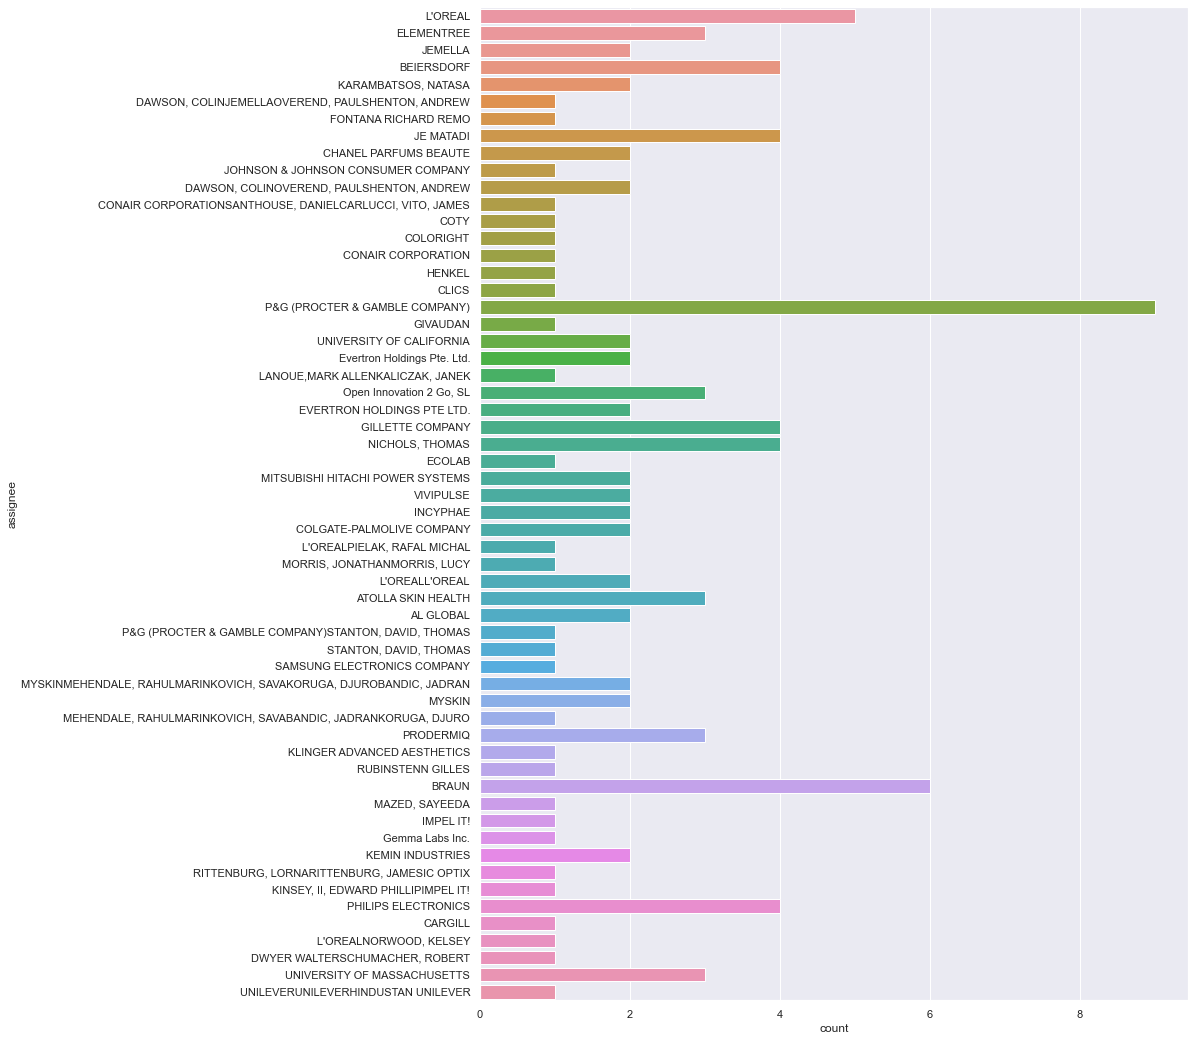

In [226]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,18.27)})
ax = sns.countplot(y="assignee", data=df_selected.drop_duplicates())

In [227]:
df[df.assignee == "P&G (PROCTER & GAMBLE COMPANY)"][["title", "ipc_classes","claims"]] 

,title,ipc_classes,claims
1561,method of determining authenticity of a consumer good,"G06K19/06, G06K7/14, G06K9/62, G06N20/00, G06Q30/00",1. a method for classifying whether a subject consumer good is authentic or non-authentic comprising the steps: a) obtaining an image of the subject consumer good comprising a subject product specification; b) inputting the obtained image into a model; wherein the model is configured to classify...
5337,method of making perfumed goods,"C11B9/00, C11D3/50","1. a method comprising: a.) using an odt value determined by mathematical modelling to select one or more perfume raw materials; b.) combining and/or processing said one or more perfume raw materials with one or more additional materials to form a product.2. the method of claim 1, wherein said p..."
7562,system and method for guiding a user to take a selfie,"G06K9/00, G06K9/20","what is claimed is:1. a system for improving the quality of a selfie, comprising:a. an image capture device;b. a computer coupled to the image capture device, the computer comprising a nontransitory memory component with logic stored thereon, wherein the logic comprises i. an image processing mo..."
15374,method of generating user feedback information to enhance product use results,"A45D44/00, G06Q30/02, G06Q30/06","1. a computing device for providing feedback regarding skin care products, the computing device comprising: a user interface; a communication interface; one or more processors; and a non-transitory computer-readable memory coupled to the one or more processors, the user interface, and the commun..."
15677,system and a method for providing and visualizing information of a fabric product,"G06N20/00, G06N3/02, G06T7/00","1. a method for determining a damage level of a textile, comprising: receiving an image of at least a part of the textile; receiving information about a fabric type of the at least a part of the textile; analyzing the image by using a machine learning method so as to identify a fabric attribute ..."
20316,method and system for identifying a biomarker indicative of health condition,C12Q1/68,"1. a method of identifying a biomarker indicative of a subject mammal's condition, comprising the steps: a) selecting a first set of test mammals having a first disease; b) obtaining a first oral sample containing a first microbial community from each of the first set of test mammals having the ..."
21081,property-space similarity modeling,"G06Q10/00, G06Q10/10","1. a process of high through put virtual screening while maintaining confidentiality comprising a provider providing a device comprising decision software to a receiving party, said device and/or software structured such that said provider cannot access said receiving party's inputs into said de..."
24039,apparatus and method for determining cosmetic skin attributes,"A45D44/00, A61B5/00, A61B5/103, G06K9/00, G06K9/20, G06K9/46, G16H50/20, G16H50/30, G16H50/70","1. a method of determining a cosmetic skin attribute of a person, the method comprising: a) obtaining at least one color channel image comprising at least one portion of skin of the person; b) analyzing the at least one color channel image using entropy statistics to obtain an entropy value; and..."
24308,apparatus and method for operating a personal grooming appliance or household cleaning appliance,"A46B13/02, A46B15/00, A47L9/28, G05B13/02, G09B19/00","1. a method for operating a household cleaning appliance, comprising: providing a household cleaning appliance including, a powered and electronically controlled cleaning implement, and at least one physical sensor taken from a group consisting of: an orientation sensor, an acceleration sensor, ..."
29285,systems and methods for hair coverage analysis,"G06N20/00, G06N3/08, G06T7/00",1. a hair analysis system comprising: a) an image capture unit to capture an image at least of the top of the head of a user and to send the image to a hair analysis unit; b) a hair analysis unit: to analyz

In [ ]:
grooming instrument configured to monitor hair loss/growth
method for determining parameters specific to the customised hair-colouring of a given individual	

In [213]:
df_selected[df_original.columns].drop_duplicates().to_csv("selected_patents.csv", index=None)

In [70]:
##### VECCHIO CODICE:

In [49]:
df_selected[["filename"]].to_excel("selected_patents_filename.xlsx", index=False, header=False)

In [50]:
df_selected.to_excel("selected_patents.xlsx", index=False)

In [417]:
for ipc in very_interesting_ipc_classes:
    try:
        print(f"{ipc}: {ipc_class_dict[ipc].split(' - ')[-1]}")
    except:
        print(f"{ipc}: none")

A45D44/00: A45D44/00: Other cosmetic or personal care articles, e.g. for hairdressers' rooms + 
A45D29/14: A45D29/14: Manicuring or pedicuring implements + motor-driven
A45D29/00: A45D29/00: Manicuring or pedicuring + 
A61K8/00: A61K8/00: Cosmetics or similar toilet preparations + 
A61Q1/00: A61Q1/00: Make-up preparations; Body powders; Preparations for removing make-up + 
A61Q15/00A61Q19/10: none
C11B9/00: C11B9/00: Essential oils; Perfumes + 
A23L27/10: A23L27/10: Spices; Flavouring agents or condiments; Artificial sweetening agents; Table salts; Dietetic salt substitutes; Preparation or treatment thereof + Natural spices, flavouring agents or condiments; Extracts thereof
A45D34/04: A45D34/04: Containers or accessories specially adapted for handling liquid toilet or cosmetic substances, e.g. perfumes + Appliances specially adapted for applying liquid, e.g. using roller or ball
A45D31/00: A45D31/00: Artificial nails + 
A46B9/04: A46B9/04: Arrangements of the bristles in the brush body